In [1]:
import sys
from pathlib import Path
import os
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

In [82]:
import schemdraw
from schemdraw import flow

import pandas as pd
import numpy as np

from lifelines import KaplanMeierFitter
#from lifelines_fix import add_at_risk_counts
from lifelines.plotting import add_at_risk_counts
from lifelines import AalenJohansenFitter
import warnings

import matplotlib.pyplot as plt 
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
%matplotlib inline

In [83]:
from matplotlib.pyplot import Text

# Loading Data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/maia-sh/direcct2/master/data/analysis/kaplan-meier-time-to-pub.csv?token=GHSAT0AAAAAABSHEFNCNS5N3PZCNICRQUBMYUPLD7A')
df.head()

,id,date_completion,publication_preprint,publication_article,publication_summary,publication_any,date_publication_preprint,date_publication_article,date_publication_summary,date_publication_any,time_publication_preprint,time_publication_article,time_publication_summary,time_publication_any
0,tri00002,2020-04-30,True,True,False,True,2020-03-23,2020-05-19,NaN,2020-03-23,-38.0,19.0,NaN,-38.0
1,tri00022,2020-04-16,False,True,False,True,NaN,2020-08-13,NaN,2020-08-13,NaN,119.0,NaN,119.0
2,tri00043,2020-06-30,False,True,False,True,NaN,2020-05-28,NaN,2020-05-28,NaN,-33.0,NaN,-33.0
3,tri00047,2020-05-10,True,True,False,True,2020-08-29,2021-03-09,NaN,2020-08-29,111.0,303.0,NaN,111.0
4,tri00049,2020-05-31,True,True,False,True,2021-02-03,2021-09-16,NaN,2021-02-03,248.0,473.0,NaN,248.0


In [4]:
#Making a copy to mess around with
df2 = df.copy()

In [5]:
results_cutoff = pd.to_datetime('2021-08-15')

To Do: 
1. Remove dates after August 15th 2021 (or other date this gets changes to) XX
2. Fix what this does to other columns XX
2. Zero out negative follow-ups
3. Create columns accounting for censorship XX
4. Make date into dates XX
5. Prepare for A-J
6. Write sanity checks

# Making Dates into Dates

In [6]:
for x in df2.columns:
    if 'date' in x:
        df2[x] = pd.to_datetime(df2[x])

# Filtering out post cut-off dates

In [8]:
df2['date_publication_preprint_adj'] = np.where(df2.date_publication_preprint > results_cutoff, pd.NaT, df2.date_publication_preprint)
df2['date_publication_preprint_adj'] = pd.to_datetime(df2['date_publication_preprint_adj'])

In [9]:
df2['date_publication_article_adj'] = np.where(df2.date_publication_article > results_cutoff, pd.NaT, df2.date_publication_article)
df2['date_publication_article_adj'] = pd.to_datetime(df2['date_publication_article_adj'])

In [10]:
df2['date_publication_summary_adj'] = np.where(df2.date_publication_summary > results_cutoff, pd.NaT, df2.date_publication_summary)
df2['date_publication_summary_adj'] = pd.to_datetime(df2['date_publication_summary_adj'])

# Then we need to re-create the other columns from that adjusted data

In [11]:
#Reporting variables
df2['publication_preprint_adj'] = np.where(df2['date_publication_preprint_adj'].notnull(), True, False)
df2['publication_article_adj'] = np.where(df2['date_publication_article_adj'].notnull(), True, False)
df2['publication_summary_adj'] = np.where(df2['date_publication_summary_adj'].notnull(), True, False)
df2['publication_any_adj'] = np.where(df2['publication_preprint_adj'] | df2['publication_article_adj'] | df2['publication_summary_adj'], True, False)

In [15]:
#Time to reporting by route
df2['time_publication_preprint_adj'] = np.where(df2.publication_preprint_adj, 
                                                (df2.date_publication_preprint_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

df2['time_publication_article_adj'] = np.where(df2.publication_article_adj, 
                                                (df2.date_publication_article_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

df2['time_publication_summary_adj'] = np.where(df2.publication_summary_adj, 
                                                (df2.date_publication_summary_adj - df2.date_completion) / pd.Timedelta('1 day'),
                                                (results_cutoff - df2.date_completion) / pd.Timedelta('1 day'))

In [19]:
#Time to reporting any

df2['time_reporting_any_adj'] = df2[['time_publication_preprint_adj', 'time_publication_article_adj', 'time_publication_summary_adj']].min(axis=1)

# Overall Reporting Rate

In [128]:
df2.publication_any_adj.value_counts()

False    1191
True      395
Name: publication_any_adj, dtype: int64

In [129]:
395/len(df2)

0.24905422446406053

# Data Handling for A-J curves for time to preprint with article pub as a competing risk

In [29]:
competing_risks = df2[['id', 
                      'date_completion', 
                      'date_publication_article_adj', 
                      'date_publication_preprint_adj', 
                      'time_publication_article_adj', 
                      'time_publication_preprint_adj']].reset_index(drop=True)

In [30]:
cr_conds = [
    competing_risks.time_publication_preprint_adj <= competing_risks.time_publication_article_adj,
    (competing_risks.date_publication_article_adj.notnull() & competing_risks.date_publication_preprint_adj.isna())]

cr_out = [competing_risks.time_publication_preprint_adj, competing_risks.time_publication_article_adj]

competing_risks['time_cr'] = np.select(cr_conds, cr_out)

cr_event_conds = [
    competing_risks.date_publication_preprint_adj.notnull(),
    competing_risks.date_publication_preprint_adj.isna() & competing_risks.date_publication_article_adj.notnull(),
    competing_risks.date_publication_preprint_adj.isna() & competing_risks.date_publication_article_adj.isna()]

cr_event_out = [1, 2, 0]

competing_risks['event_cr'] = np.select(cr_event_conds, cr_event_out)
competing_risks['time_cr'] = np.where(competing_risks['time_cr'] < 0, 0, competing_risks['time_cr'])

In [31]:
d = competing_risks[['time_cr', 'event_cr']].reset_index(drop=True)
d = d.set_index('time_cr')

In [34]:
aj = AalenJohansenFitter(seed=10)

#This just hides the warning that data is randomly "jiggered" to break ties, which is fine.
#The seed for this is set above
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    aj.fit(competing_risks.time_cr, competing_risks.event_cr, event_of_interest=1)

In [35]:
aj_corrected = aj.cumulative_density_.reset_index()
aj_corrected = aj_corrected.set_index(aj_corrected.event_at.apply(round)).drop('event_at', axis=1)

In [36]:
d = aj_corrected.merge(d, how='outer', left_index=True, right_index=True)
d = d.loc[d['event_cr'] == 0].copy()

# Any Publication

In [21]:
any_pub = df2[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
any_pub['publication_any_adj'] = any_pub['publication_any_adj'].astype(int)
any_pub['time_reporting_any_adj'] = np.where(any_pub['time_reporting_any_adj'] < 0, 0, any_pub['time_reporting_any_adj'])

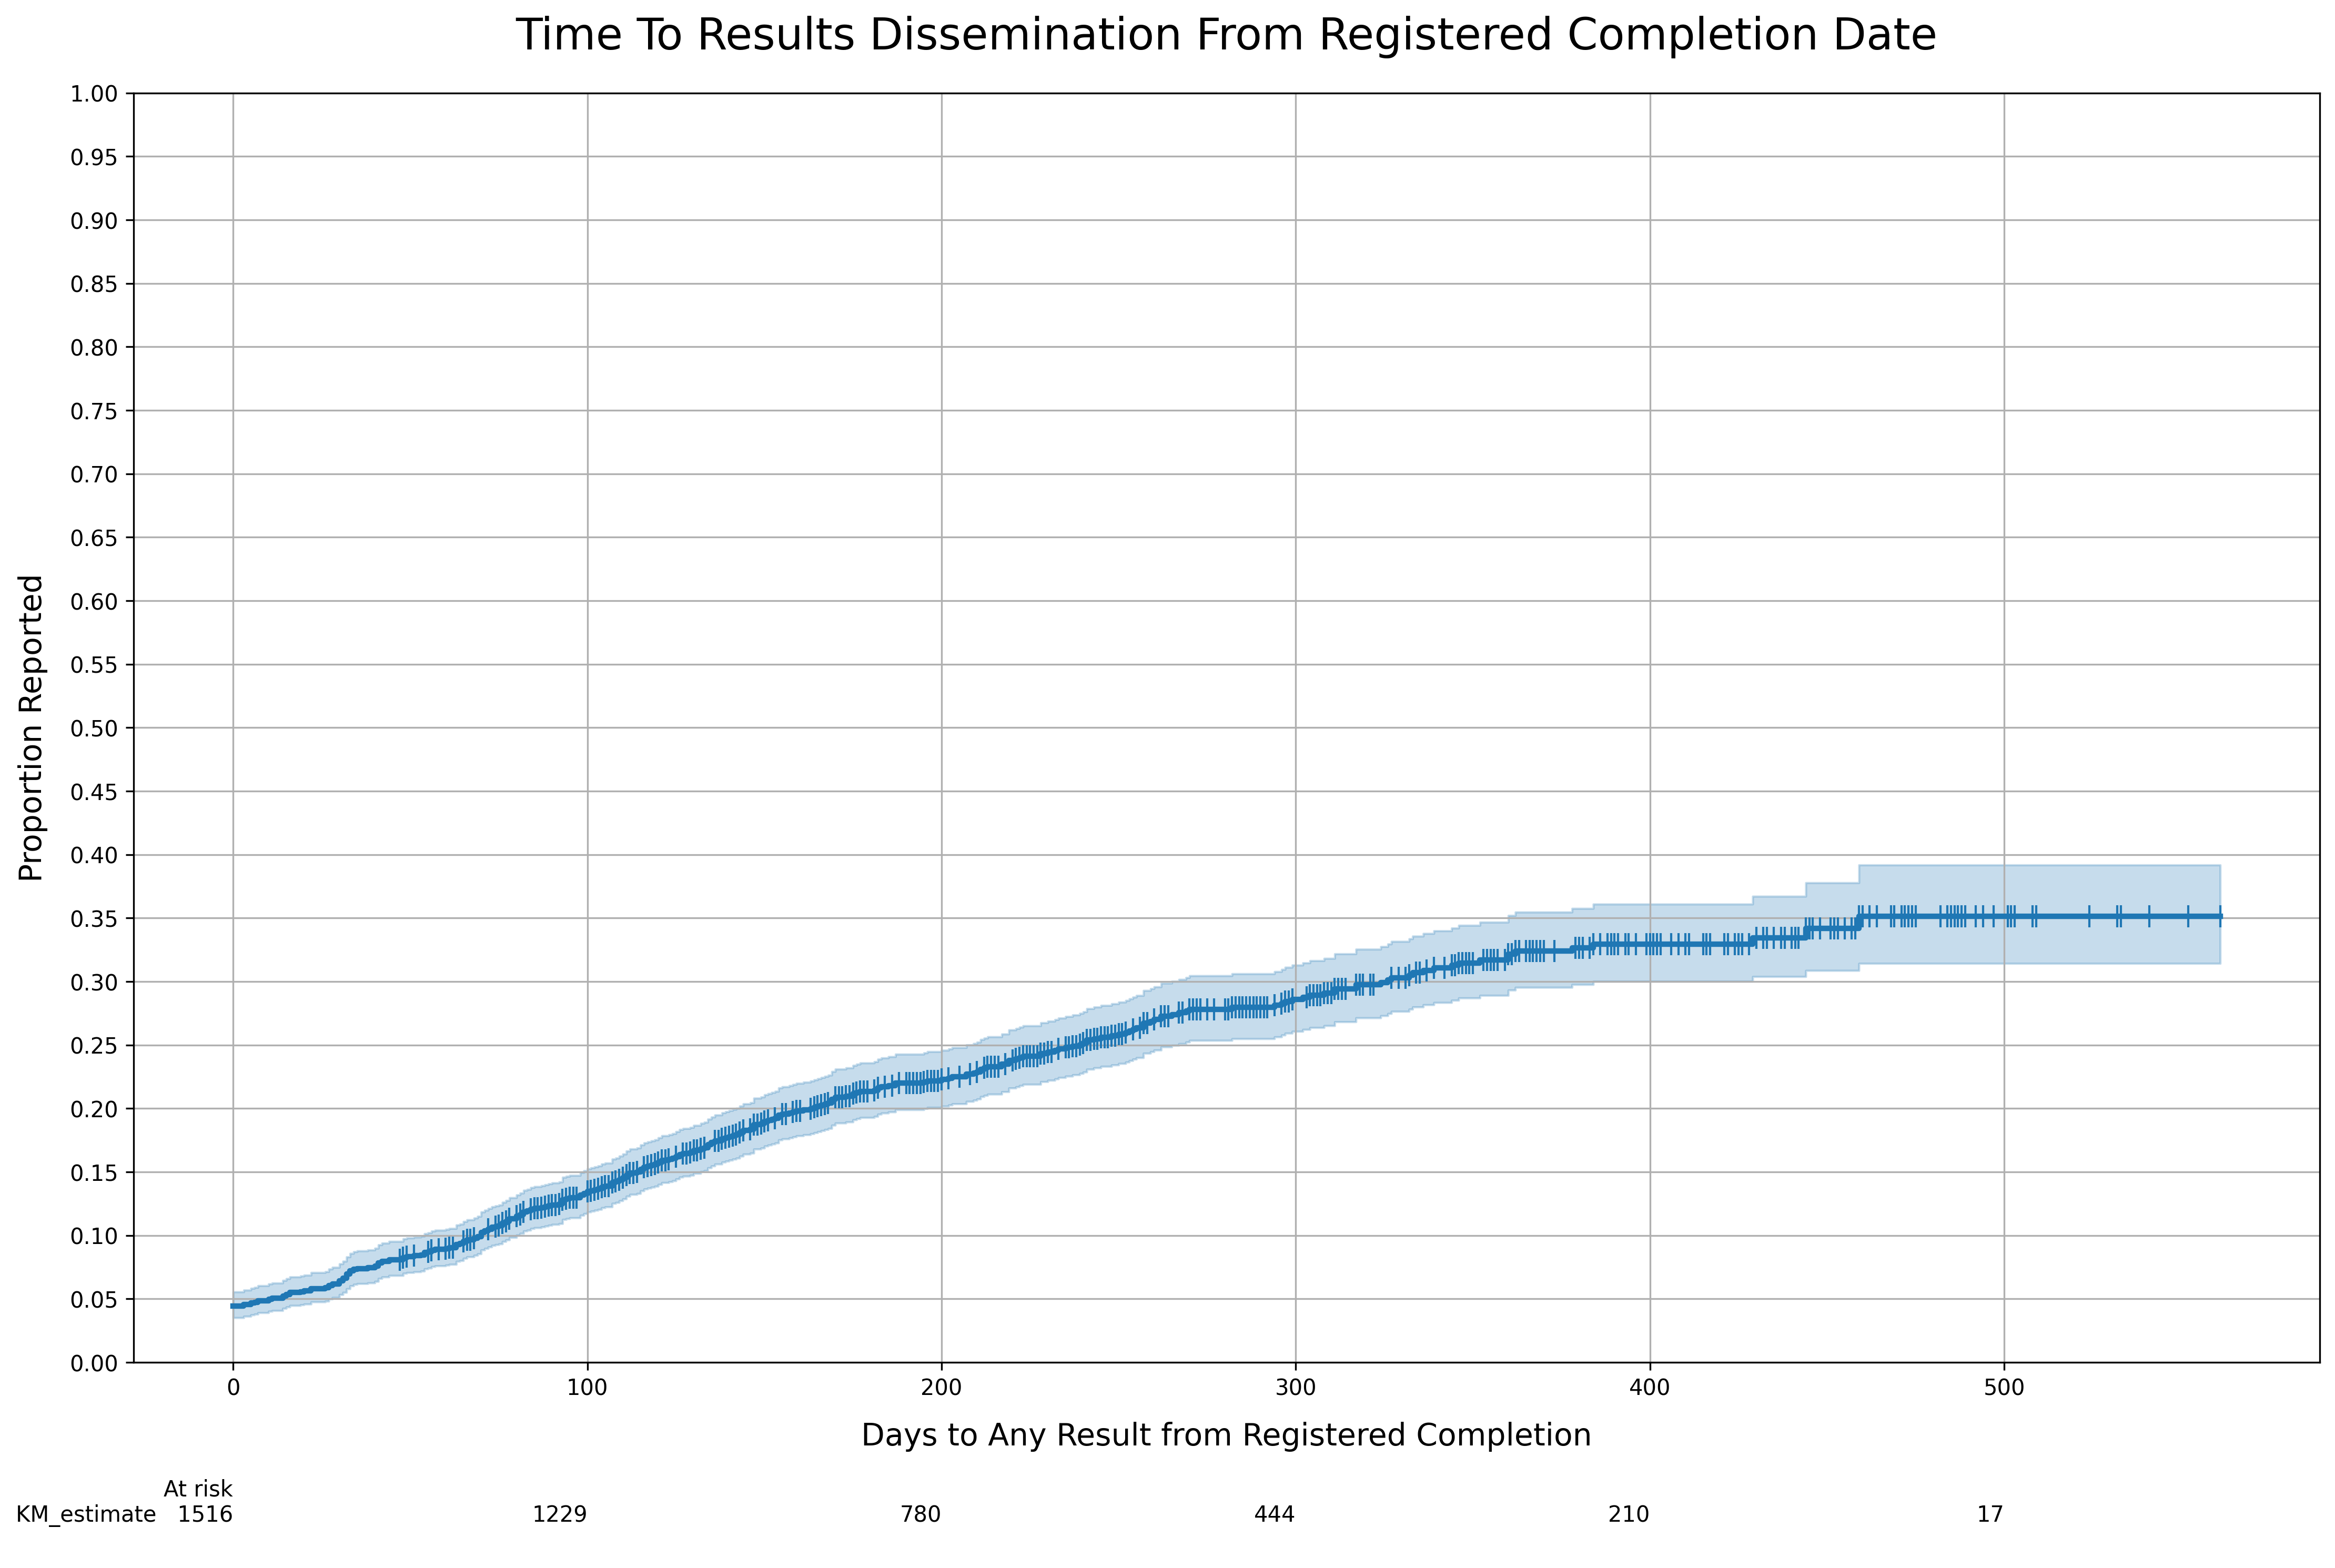

In [27]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = any_pub.time_reporting_any_adj
E = any_pub.publication_any_adj

kmf_any = KaplanMeierFitter()
kmf_any.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_any.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Article Publication

In [39]:
article_pub = df2[['publication_article_adj', 'time_publication_article_adj']].reset_index(drop=True)
article_pub['publication_article_adj'] = article_pub['publication_article_adj'].astype(int)
article_pub['time_publication_article_adj'] = np.where(article_pub['time_publication_article_adj'] < 0, 0, article_pub['time_publication_article_adj'])

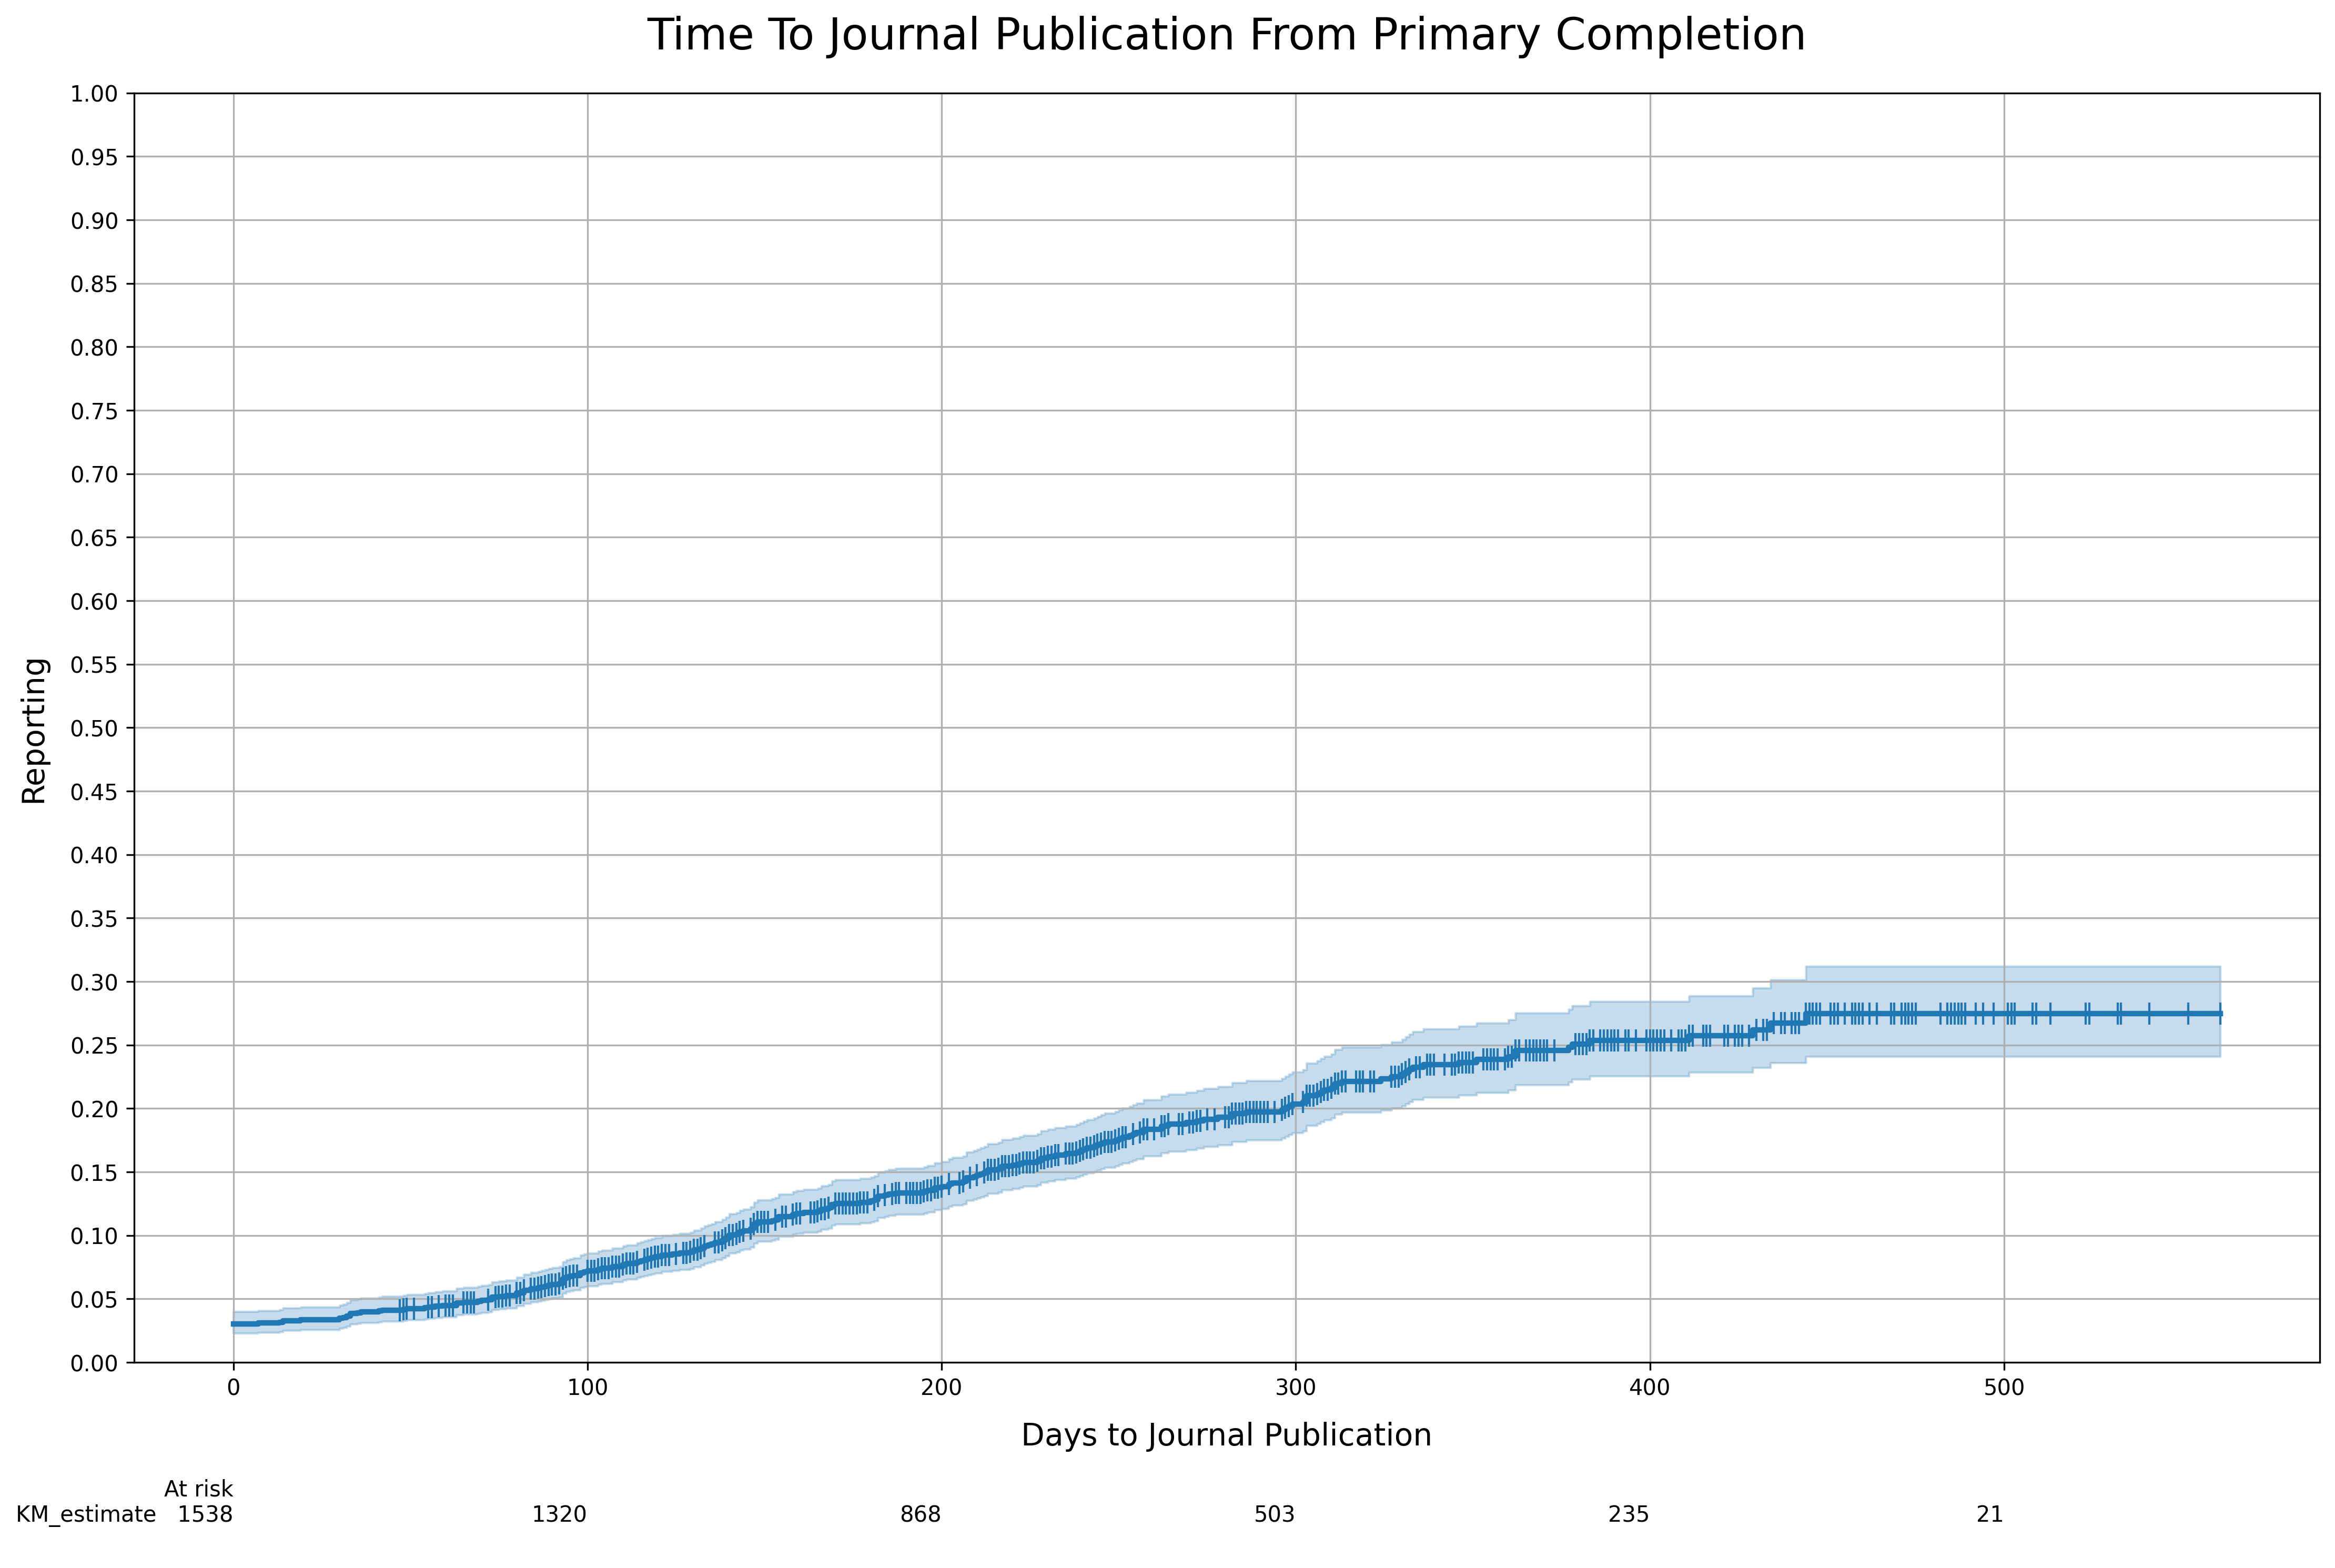

In [42]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = article_pub.time_publication_article_adj
E = article_pub.publication_article_adj

kmf_article = KaplanMeierFitter()
kmf_article.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_article.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Journal Publication From Primary Completion", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_article, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Time to Preprint Publication (with article pub as competing risk)

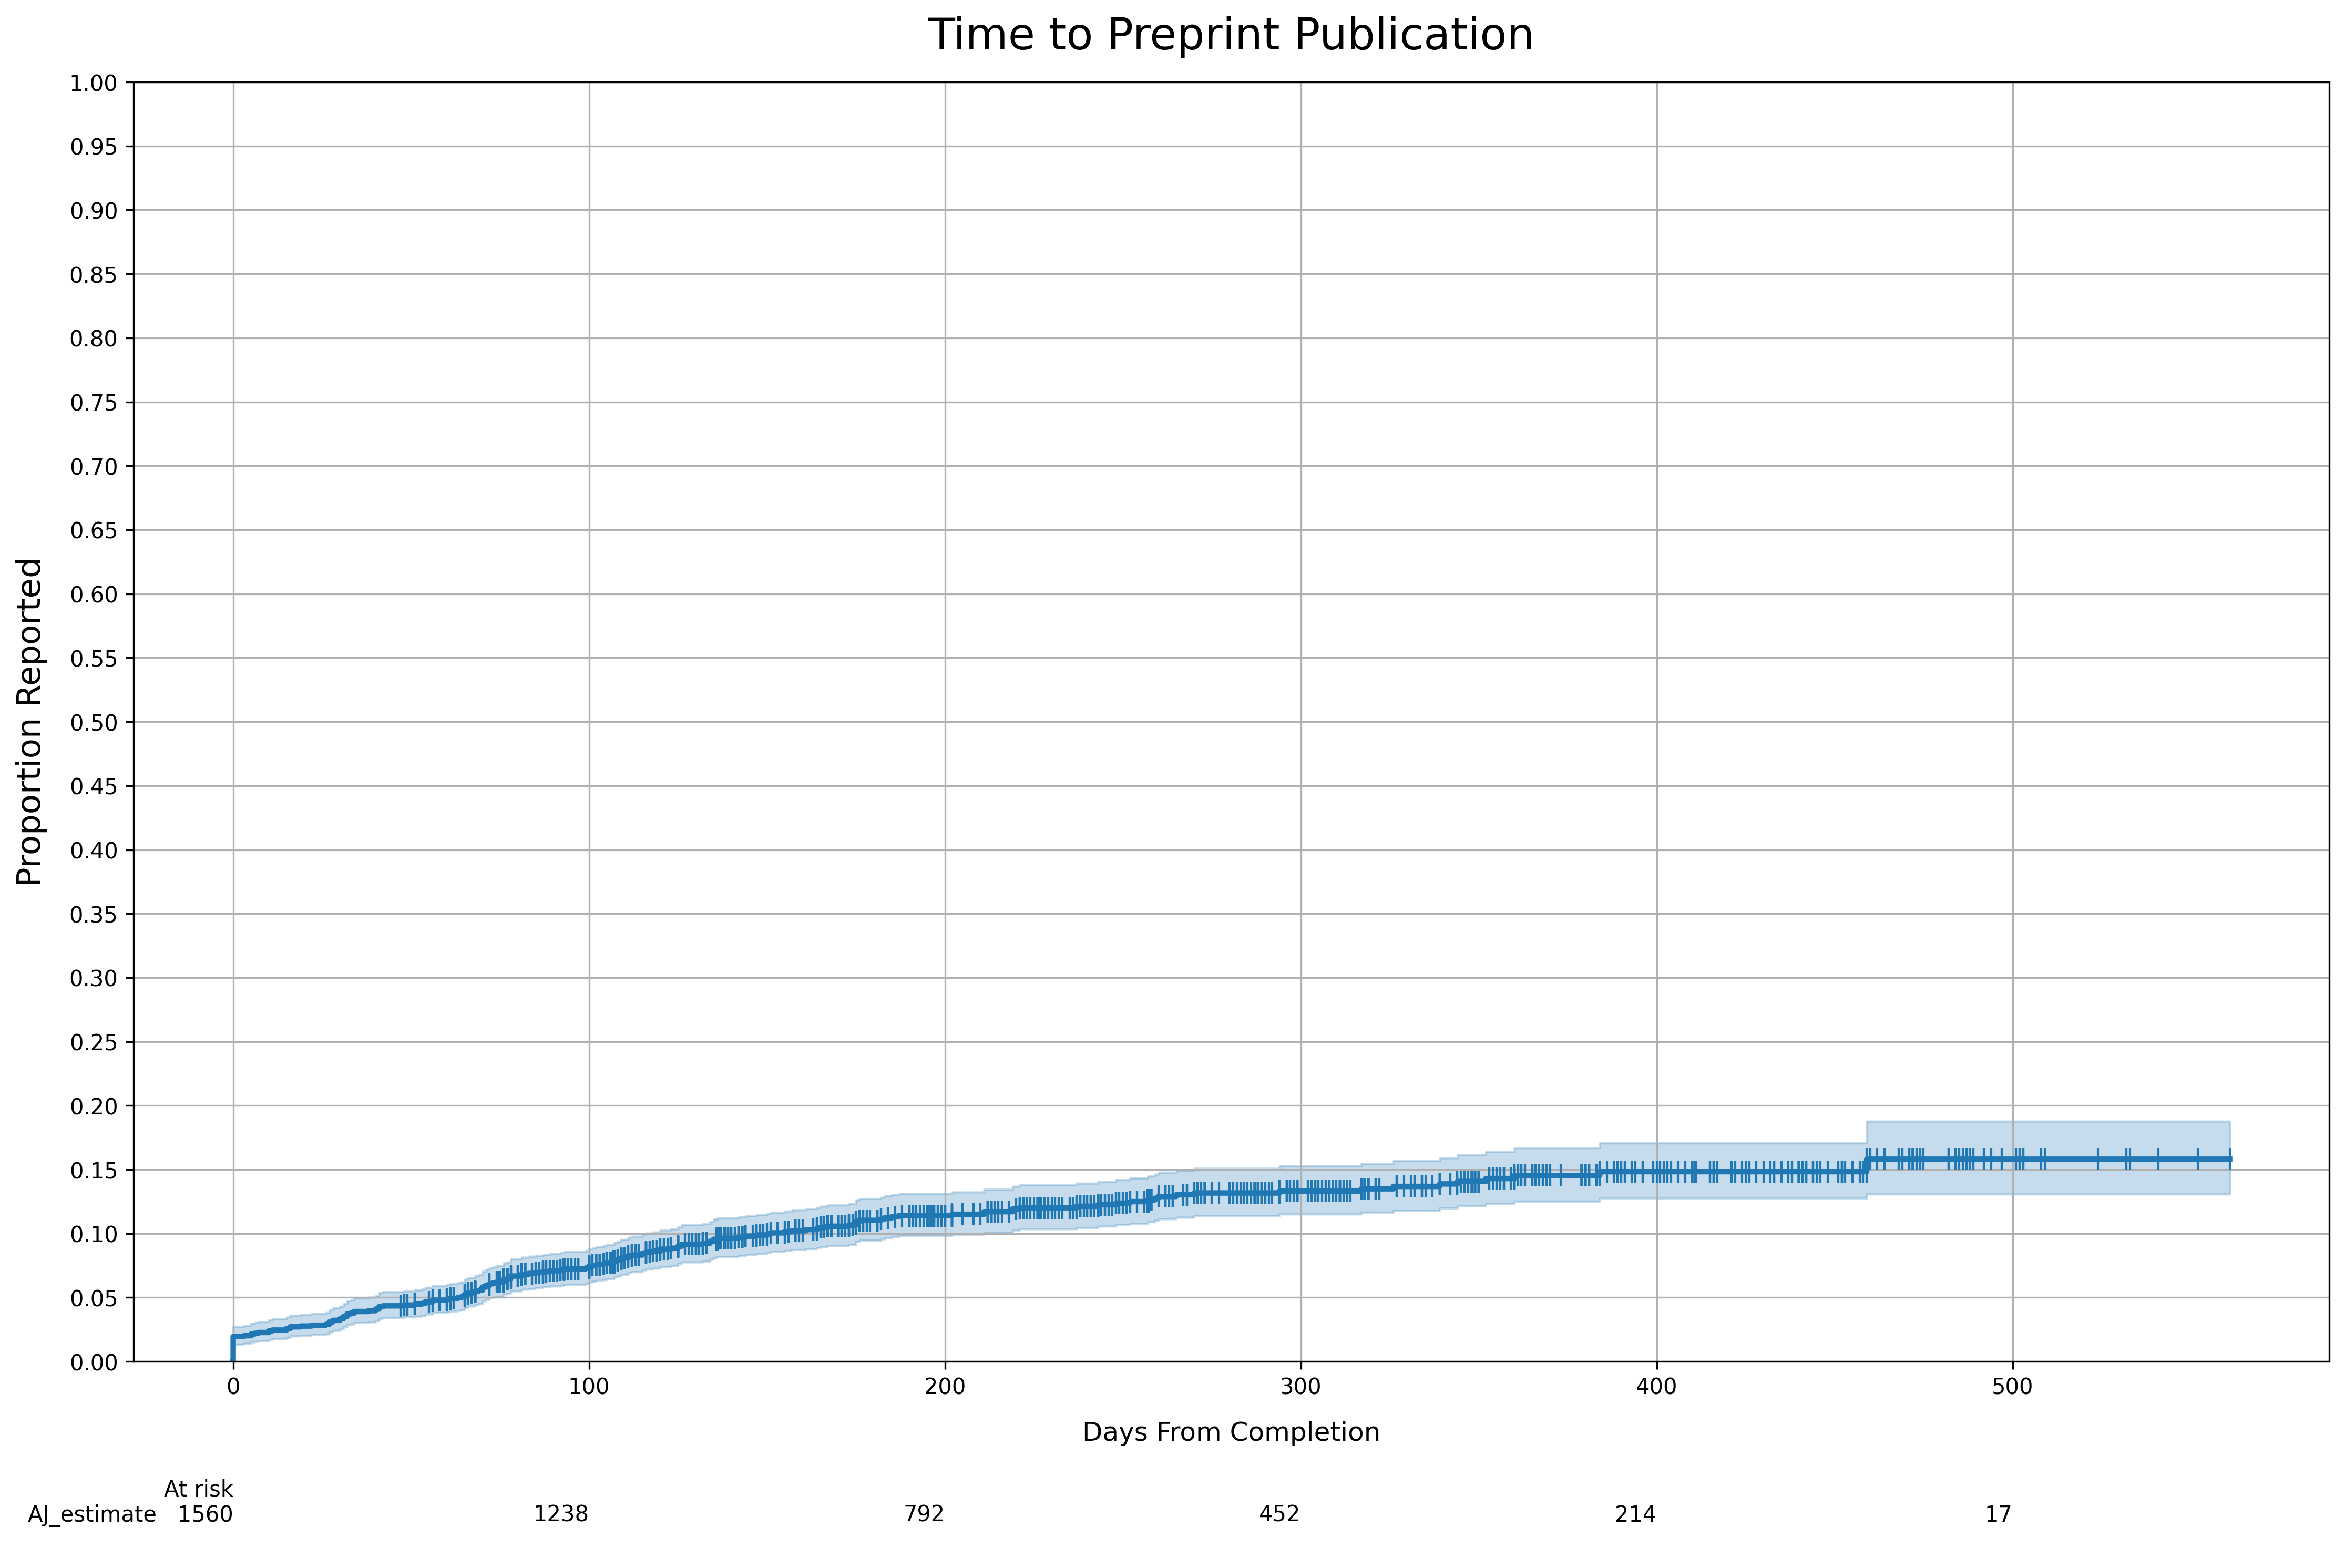

In [45]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

aj = AalenJohansenFitter(seed=10)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    aj.fit(competing_risks.time_cr, competing_risks.event_cr, event_of_interest=1)
aj.plot(yticks=yticks, figsize=(15,10), lw=2.5, legend=None, grid=True)
plt.plot(d.index, d['CIF_1'], '|', markersize=10, color='C0')

plt.title('Time to Preprint Publication', pad=15, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=15)
plt.xlabel('Days From Completion', labelpad=10, fontsize=12)

ax.set_ylim([0, 1])

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(aj, rows_to_show = ['At risk'])
plt.tight_layout()
plt.show()

# Registry results
-We may want to restrict this only to registrations on registries that can accept registry results?

In [47]:
reg_pub = df2[['publication_summary_adj', 'time_publication_summary_adj']].reset_index(drop=True)
reg_pub['publication_summary_adj'] = reg_pub['publication_summary_adj'].astype(int)
reg_pub['time_publication_summary_adj'] = np.where(reg_pub['time_publication_summary_adj'] < 0, 0, reg_pub['time_publication_summary_adj'])

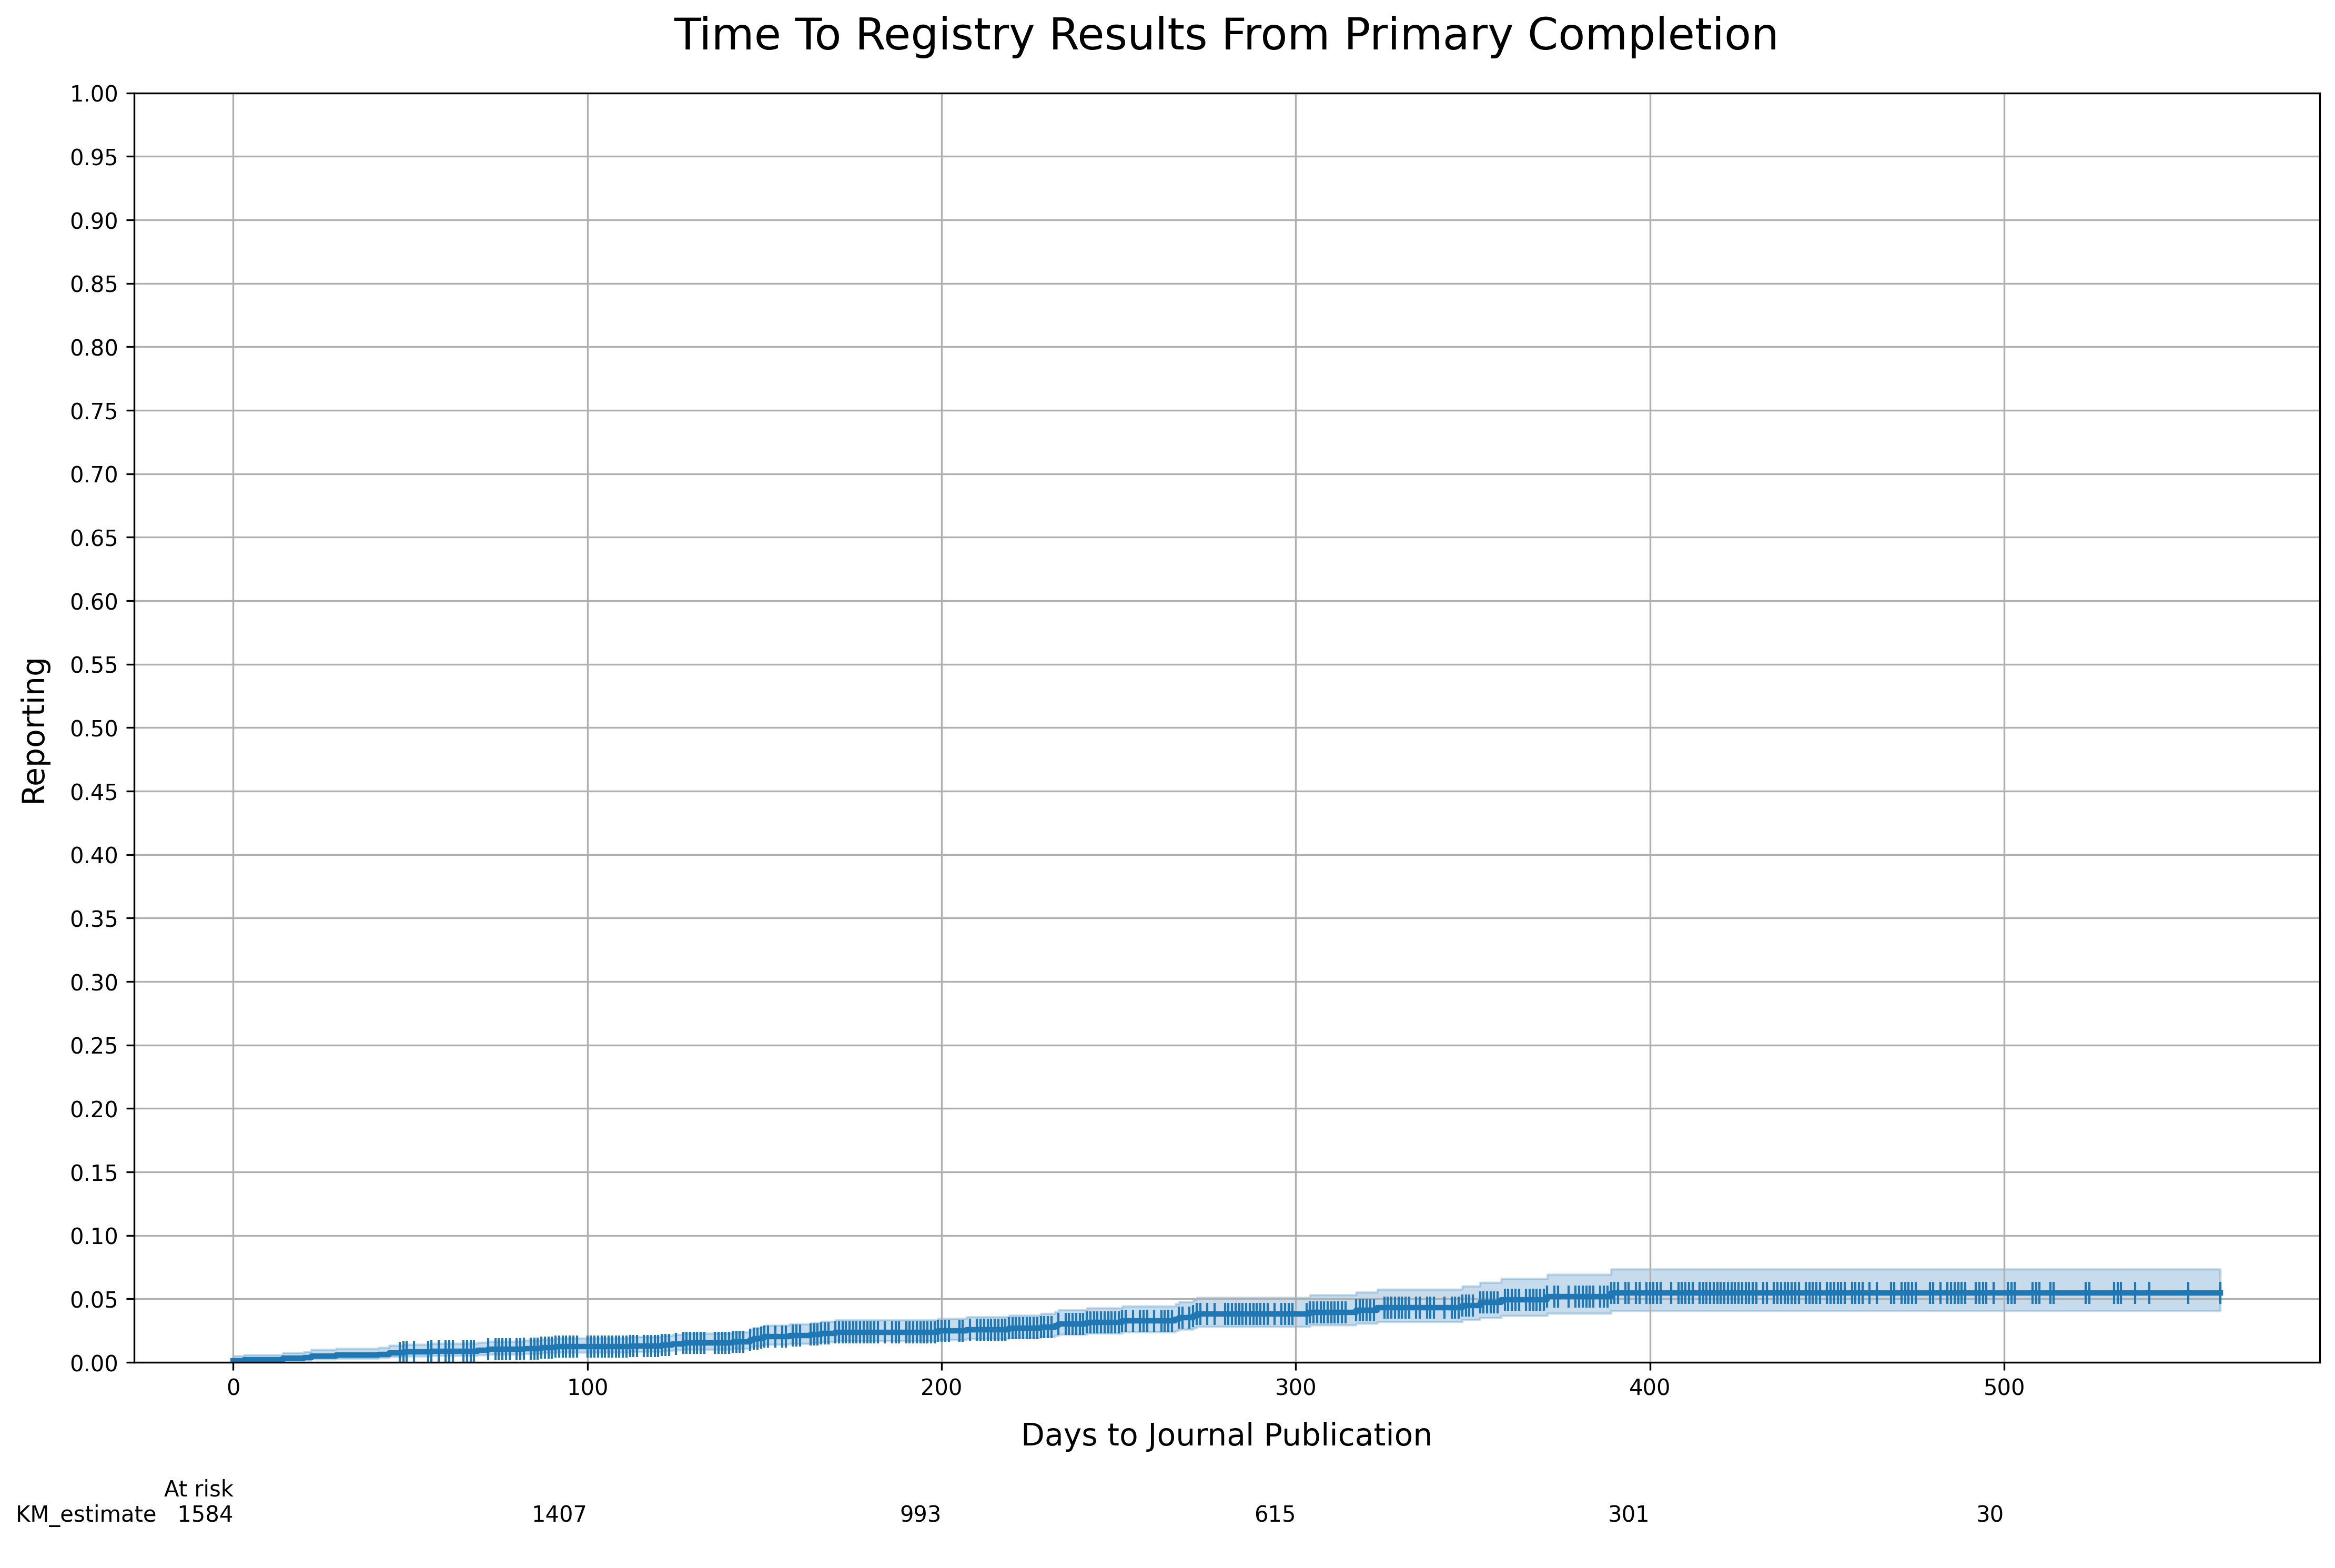

In [48]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T = reg_pub.time_publication_summary_adj
E = reg_pub.publication_summary_adj

kmf_article = KaplanMeierFitter()
kmf_article.fit(T, E)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_article.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Registry Results From Primary Completion", pad=20, fontsize=20)
plt.ylabel('Reporting', labelpad=10, fontsize=14)
plt.xlabel('Days to Journal Publication', labelpad=10, fontsize=14)

add_at_risk_counts(kmf_article, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Venn

In [53]:
venn_data = df2[['publication_preprint_adj', 'publication_article_adj', 'publication_summary_adj']].reset_index(drop=True)

In [55]:
prep = venn_data.publication_preprint_adj == True
art = venn_data.publication_article_adj == True
reg = venn_data.publication_summary_adj == True

In [65]:
len(venn_data[~art & prep & reg])

5

In [66]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
labels = ['Journal Articles', 'Registry Results', 'Preprints']
values = (167, 19, 20, 96, 79, 5, 10)


Text(0.5, 1.0, 'COVID-19 Clinical Trial Results by Dissemination Route')

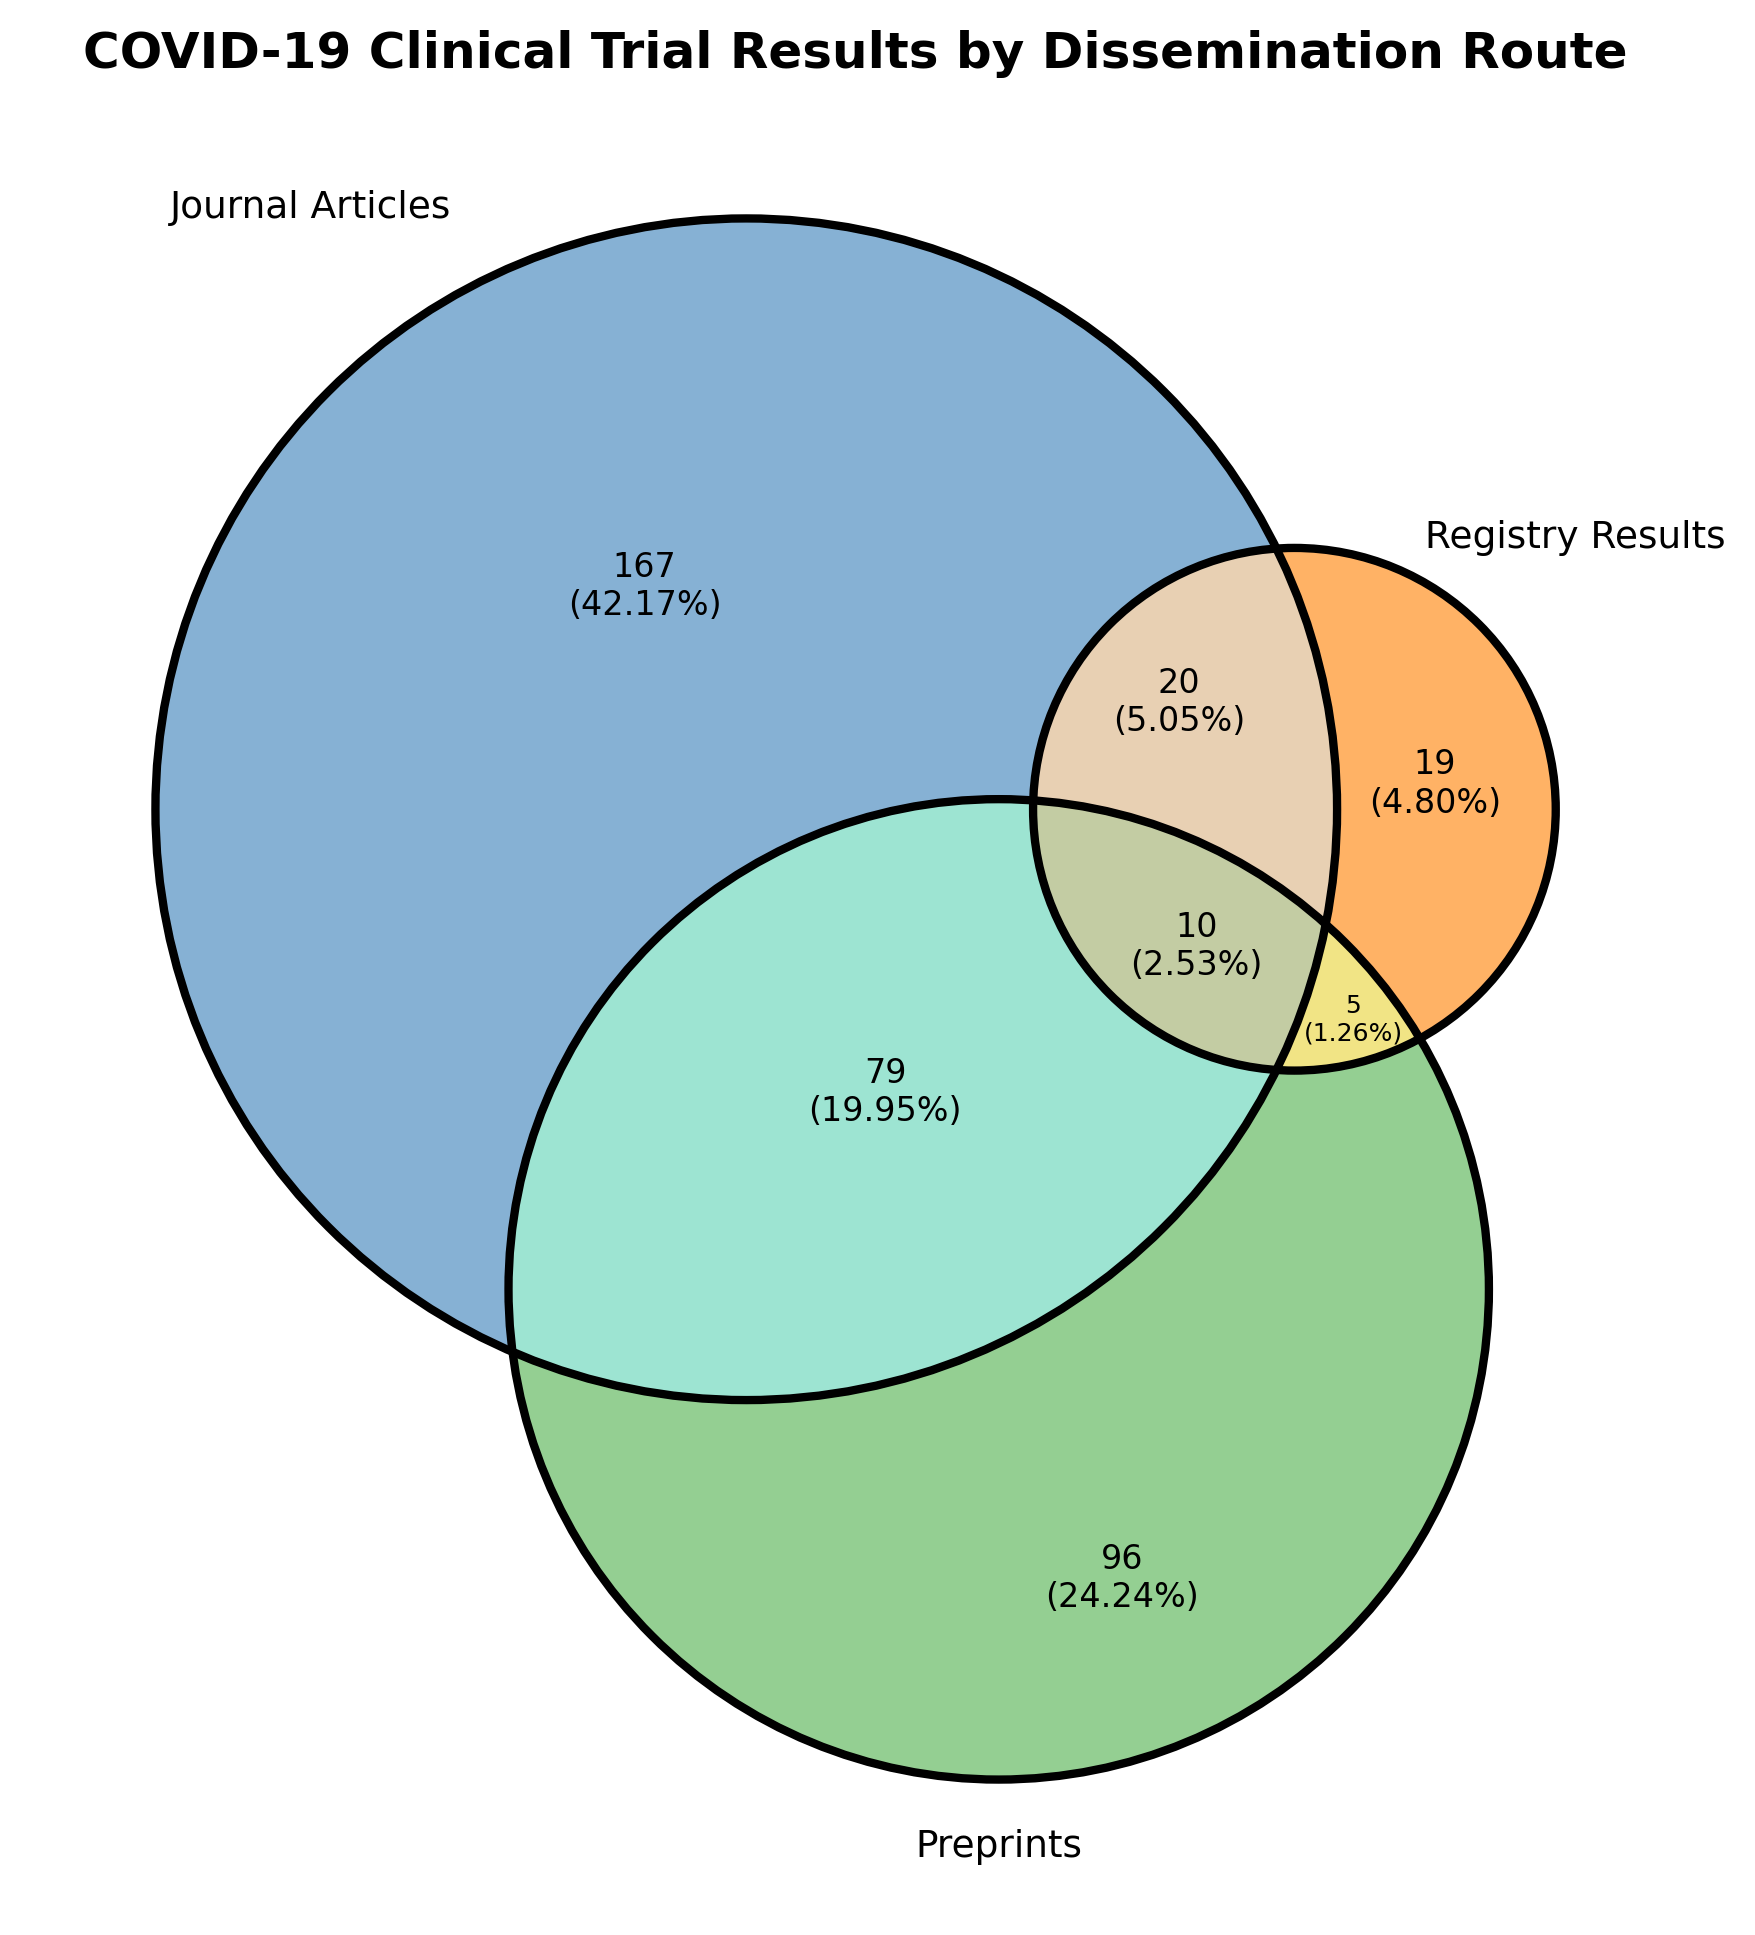

In [125]:
plt.figure(figsize=(8,8), dpi=300)
v1 = venn3(
    subsets = values, 
    set_labels = labels,
    set_colors = colors, 
    subset_label_formatter = lambda x: str(x) + "\n(" + f"{(x/sum(values)):1.2%}" + ")", 
    alpha = .6)

for text in v1.set_labels:
    text.set_fontsize(9)

for text in v1.subset_labels:
    if text == v1.subset_labels[5]:
        text.set_fontsize(6)
    else:
        text.set_fontsize(8)

v1.get_label_by_id("100").set_x(-0.2)
v1.get_label_by_id("111").set_x(.24)
v1.get_label_by_id("011").set_y(-.028)
v1.get_label_by_id("011").set_x(.365)
v1.get_label_by_id("010").set_x(.43)
v1.get_label_by_id("010").set_y(.16)

venn3_circles((167, 19, 20, 96, 79, 5, 10))
plt.title('COVID-19 Clinical Trial Results by Dissemination Route', fontweight='bold')

# Breaking Pandemic into Phases

In [133]:
phase_1 = pd.to_datetime('2020-06-30')
phase_2 = pd.to_datetime('2020-12-31')
phase_3 = pd.to_datetime('2021-06-30')


date_conds = [(df2.date_completion <= phase_1), 
              (df2.date_completion > phase_1) & (df2.date_completion <= phase_2),
              (df2.date_completion > phase_2) & (df2.date_completion <= phase_3)]

date_out = [1,2,3]

df2['pandemic_phase'] = np.select(date_conds, date_out)

In [145]:
df2[df2.pandemic_phase == 1]

,id,date_completion,publication_preprint,publication_article,publication_summary,publication_any,date_publication_preprint,date_publication_article,date_publication_summary,date_publication_any,...,date_publication_summary_adj,publication_preprint_adj,publication_article_adj,publication_summary_adj,publication_any_adj,time_publication_preprint_adj,time_publication_article_adj,time_publication_summary_adj,time_reporting_any_adj,pandemic_phase
0,tri00002,2020-04-30,True,True,False,True,2020-03-23,2020-05-19,NaT,2020-03-23,...,NaT,True,True,False,True,-38.0,19.0,472.0,-38.0,1
1,tri00022,2020-04-16,False,True,False,True,NaT,2020-08-13,NaT,2020-08-13,...,NaT,False,True,False,True,486.0,119.0,486.0,119.0,1
2,tri00043,2020-06-30,False,True,False,True,NaT,2020-05-28,NaT,2020-05-28,...,NaT,False,True,False,True,411.0,-33.0,411.0,-33.0,1
3,tri00047,2020-05-10,True,True,False,True,2020-08-29,2021-03-09,NaT,2020-08-29,...,NaT,True,True,False,True,111.0,303.0,462.0,111.0,1
4,tri00049,2020-05-31,True,True,False,True,2021-02-03,2021-09-16,NaT,2021-02-03,...,NaT,True,False,False,True,248.0,441.0,441.0,248.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,tri02883,2020-06-30,False,False,False,False,NaT,NaT,NaT,NaT,...,NaT,False,False,False,False,411.0,411.0,411.0,411.0,1
1269,tri02885,2020-05-21,False,False,False,False,NaT,NaT,NaT,NaT,...,NaT,False,False,False,False,451.0,451.0,451.0,451.0,1
1352,tri05354,2020-05-15,False,False,False,False,NaT,NaT,NaT,NaT,...,NaT,False,False,False,False,457.0,457.0,457.0,457.0,1
1489,tri07408,2020-06-30,False,False,False,False,NaT,NaT,NaT,NaT,...,NaT,False,False,False,False,411.0,411.0,411.0,411.0,1


In [144]:
df2[df2.pandemic_phase == 2]

,id,date_completion,publication_preprint,publication_article,publication_summary,publication_any,date_publication_preprint,date_publication_article,date_publication_summary,date_publication_any,...,date_publication_summary_adj,publication_preprint_adj,publication_article_adj,publication_summary_adj,publication_any_adj,time_publication_preprint_adj,time_publication_article_adj,time_publication_summary_adj,time_reporting_any_adj,pandemic_phase
5,tri00071,2020-12-31,True,True,False,True,2020-05-04,2020-05-28,NaT,2020-05-04,...,NaT,True,True,False,True,-241.0,-217.0,227.0,-241.0,2
6,tri00075,2020-08-01,False,True,False,True,NaT,2020-08-08,NaT,2020-08-08,...,NaT,False,True,False,True,379.0,7.0,379.0,7.0,2
10,tri00084,2020-07-30,False,True,False,True,NaT,2020-04-01,NaT,2020-04-01,...,NaT,False,True,False,True,381.0,-120.0,381.0,-120.0,2
11,tri00100,2020-12-31,False,True,False,True,NaT,2020-08-01,NaT,2020-08-01,...,NaT,False,True,False,True,227.0,-152.0,227.0,-152.0,2
12,tri00105,2020-08-31,True,True,False,True,2020-04-01,2020-05-27,NaT,2020-04-01,...,NaT,True,True,False,True,-152.0,-96.0,349.0,-152.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,tri08909,2020-11-15,False,False,False,False,NaT,NaT,NaT,NaT,...,NaT,False,False,False,False,273.0,273.0,273.0,273.0,2
1558,tri09159,2020-09-30,False,False,False,False,NaT,NaT,NaT,NaT,...,NaT,False,False,False,False,319.0,319.0,319.0,319.0,2
1562,tri09491,2020-08-30,False,False,False,False,NaT,NaT,NaT,NaT,...,NaT,False,False,False,False,350.0,350.0,350.0,350.0,2
1563,tri09502,2020-12-30,False,False,False,False,NaT,NaT,NaT,NaT,...,NaT,False,False,False,False,228.0,228.0,228.0,228.0,2


In [135]:
df2['pandemic_phase'].value_counts()

2    671
3    631
1    284
Name: pandemic_phase, dtype: int64

In [ ]:
#What does this look like for reporting

In [138]:
phase_pub = df2[['publication_any_adj', 'time_reporting_any_adj', 'pandemic_phase']].reset_index(drop=True)
phase_pub['publication_any_adj'] = phase_pub['publication_any_adj'].astype(int)
phase_pub['time_reporting_any_adj'] = np.where(phase_pub['time_reporting_any_adj'] < 0, 0, phase_pub['time_reporting_any_adj'])

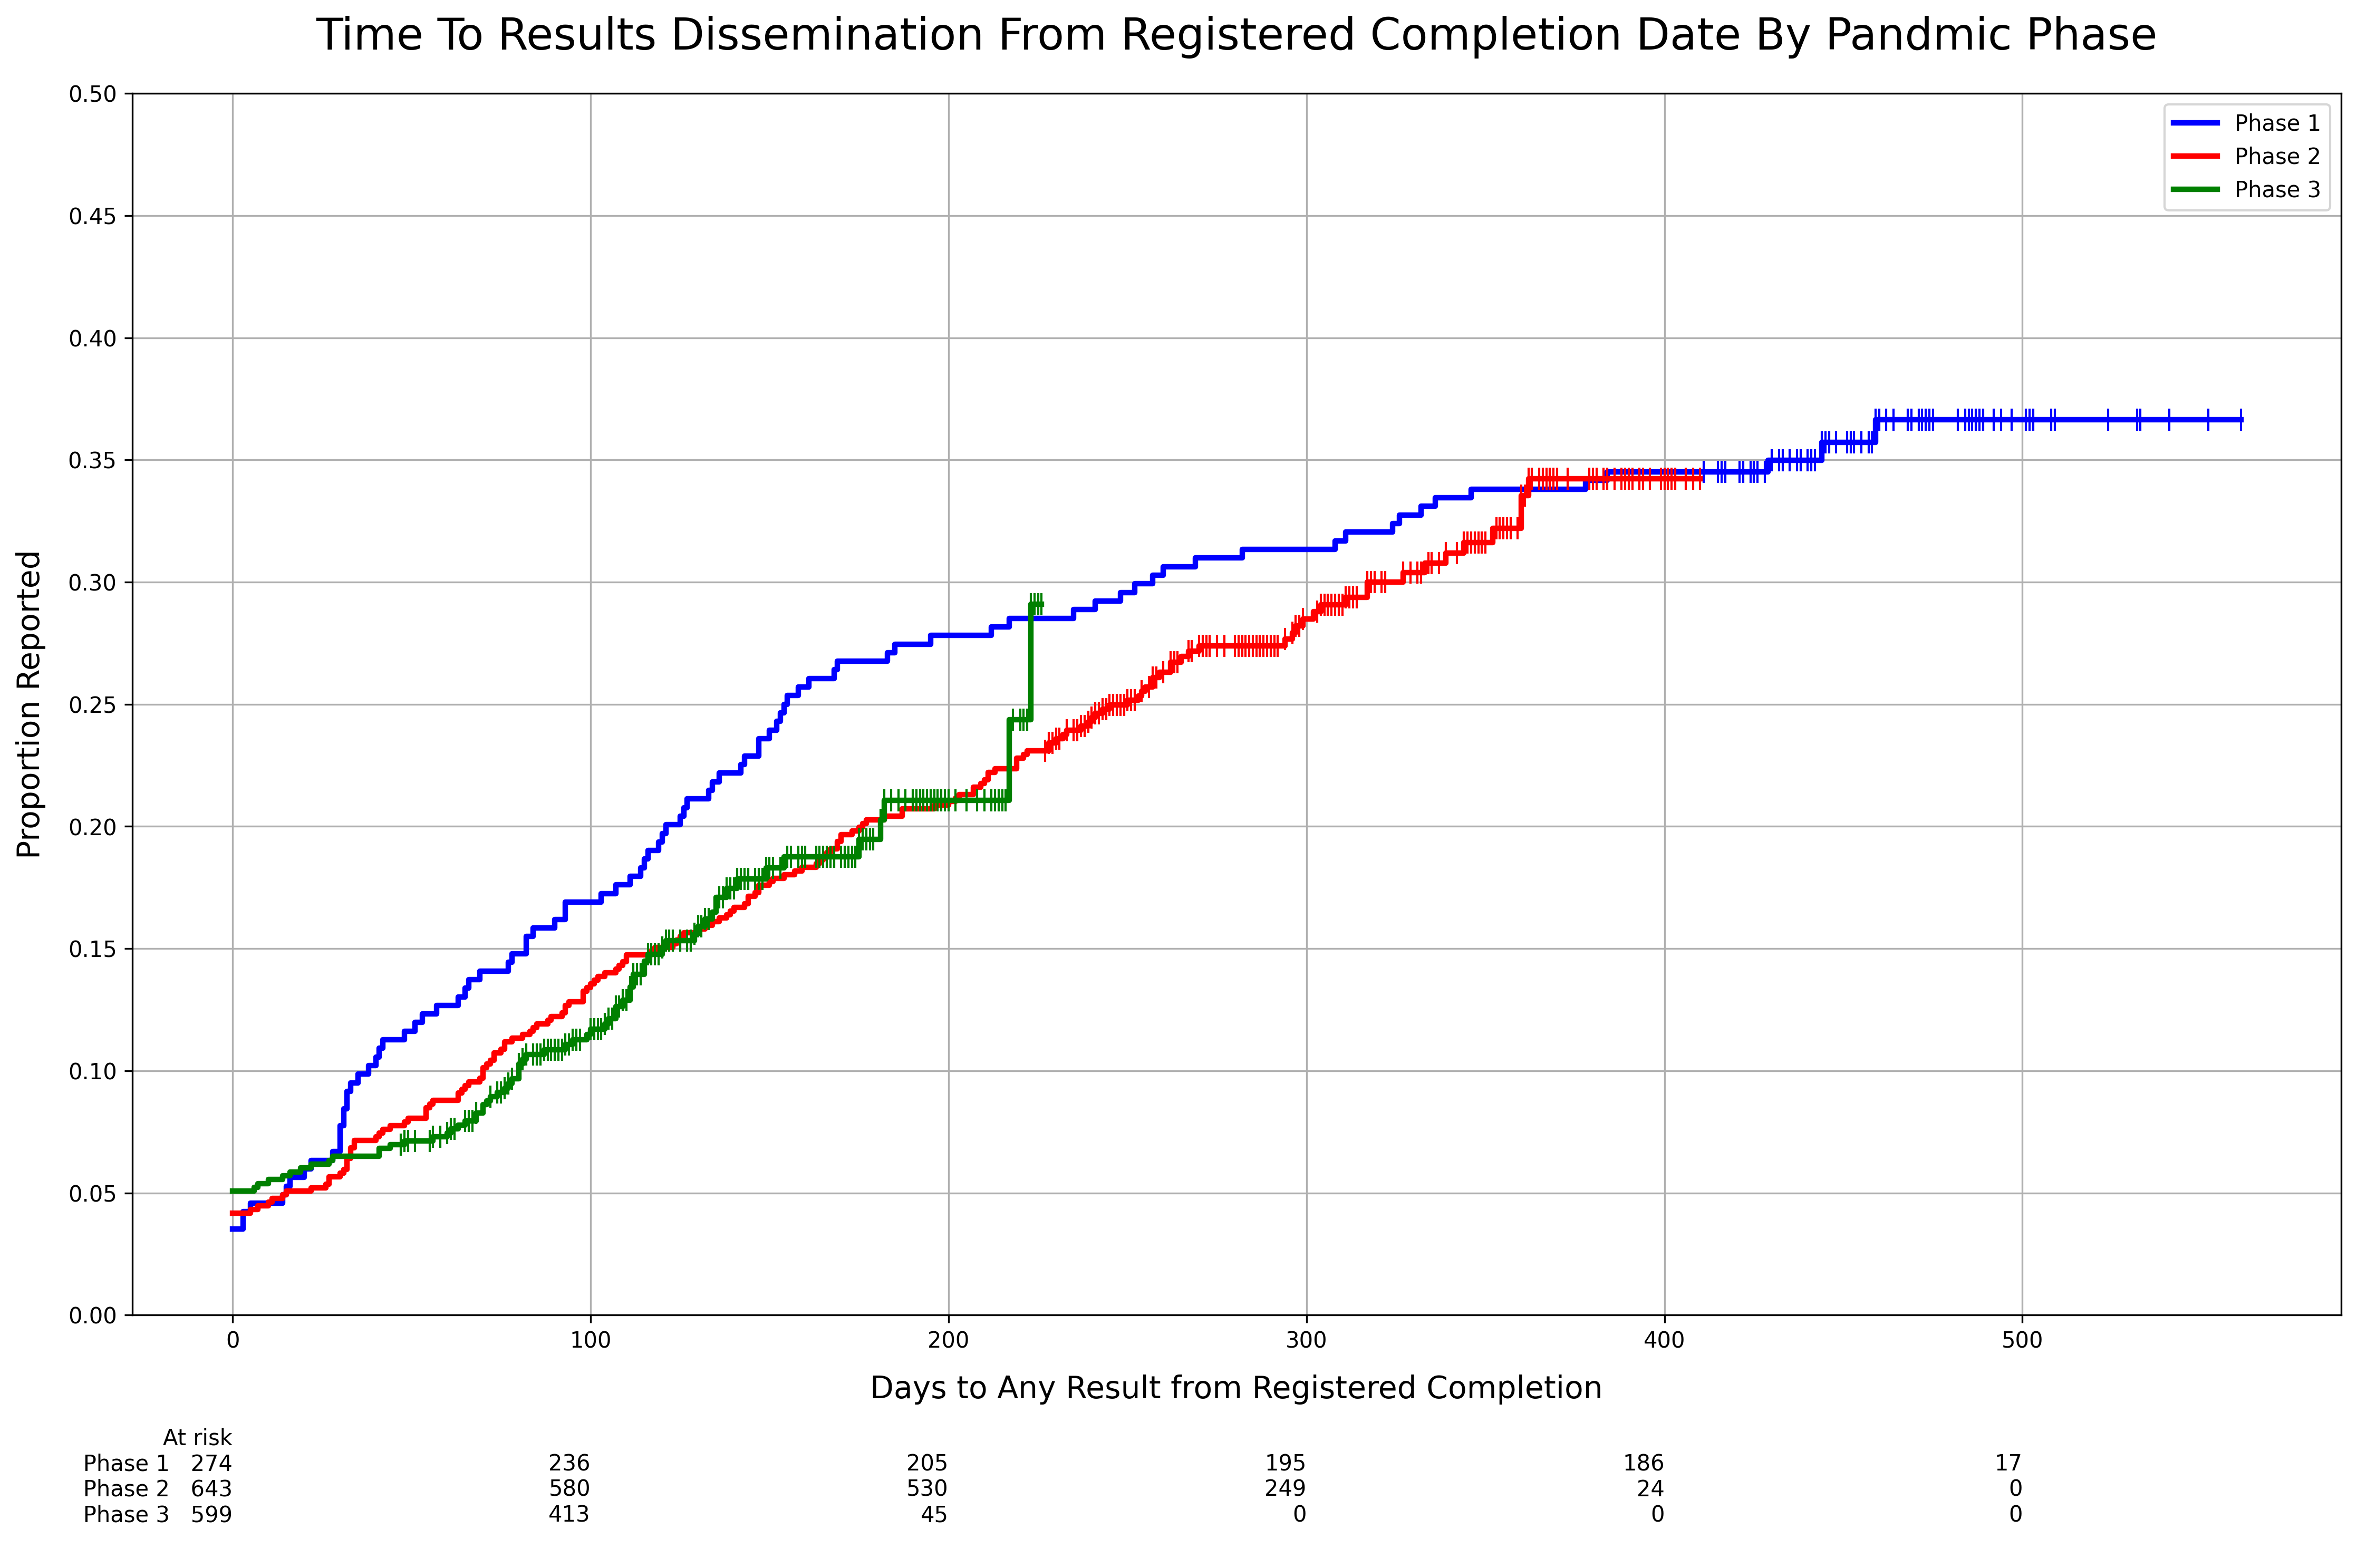

In [158]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T1 = phase_pub[phase_pub.pandemic_phase == 1].time_reporting_any_adj
E1 = phase_pub[phase_pub.pandemic_phase == 1].publication_any_adj

kmf_1 = KaplanMeierFitter()
kmf_1.fit(T1, E1, label='Phase 1')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_1.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='blue')

T2 = phase_pub[phase_pub.pandemic_phase == 2].time_reporting_any_adj
E2 = phase_pub[phase_pub.pandemic_phase == 2].publication_any_adj

kmf_2 = KaplanMeierFitter()
kmf_2.fit(T2, E2, label='Phase 2')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_2.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='red')


T3 = phase_pub[phase_pub.pandemic_phase == 3].time_reporting_any_adj
E3 = phase_pub[phase_pub.pandemic_phase == 3].publication_any_adj

kmf_3 = KaplanMeierFitter()
kmf_3.fit(T3, E3, label='Phase 3')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_3.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='green')

ax.set_ylim([0, .5])

plt.title("Time To Results Dissemination From Registered Completion Date By Pandmic Phase", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_1, kmf_2, kmf_3, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

# Interventions

In [188]:
df_int = df2.copy()

In [191]:
int_data = pd.read_csv(parent + '/data/interventions/common_ints.csv')

In [195]:
int_merge = df_int.merge(int_data, how='left', left_on='id', right_on='db_id')

In [197]:
hcq = int_merge[int_merge.HCQ > 0]
ive = int_merge[int_merge.IVE > 0]
cp = int_merge[int_merge.CP > 0]

In [228]:
len(hcq)

139

In [229]:
len(ive)

45

In [230]:
len(cp)

114

In [221]:
hcq_pub = hcq[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
hcq_pub['publication_any_adj'] = hcq_pub['publication_any_adj'].astype(int)
hcq_pub['time_reporting_any_adj'] = np.where(hcq_pub['time_reporting_any_adj'] < 0, 0, hcq_pub['time_reporting_any_adj'])

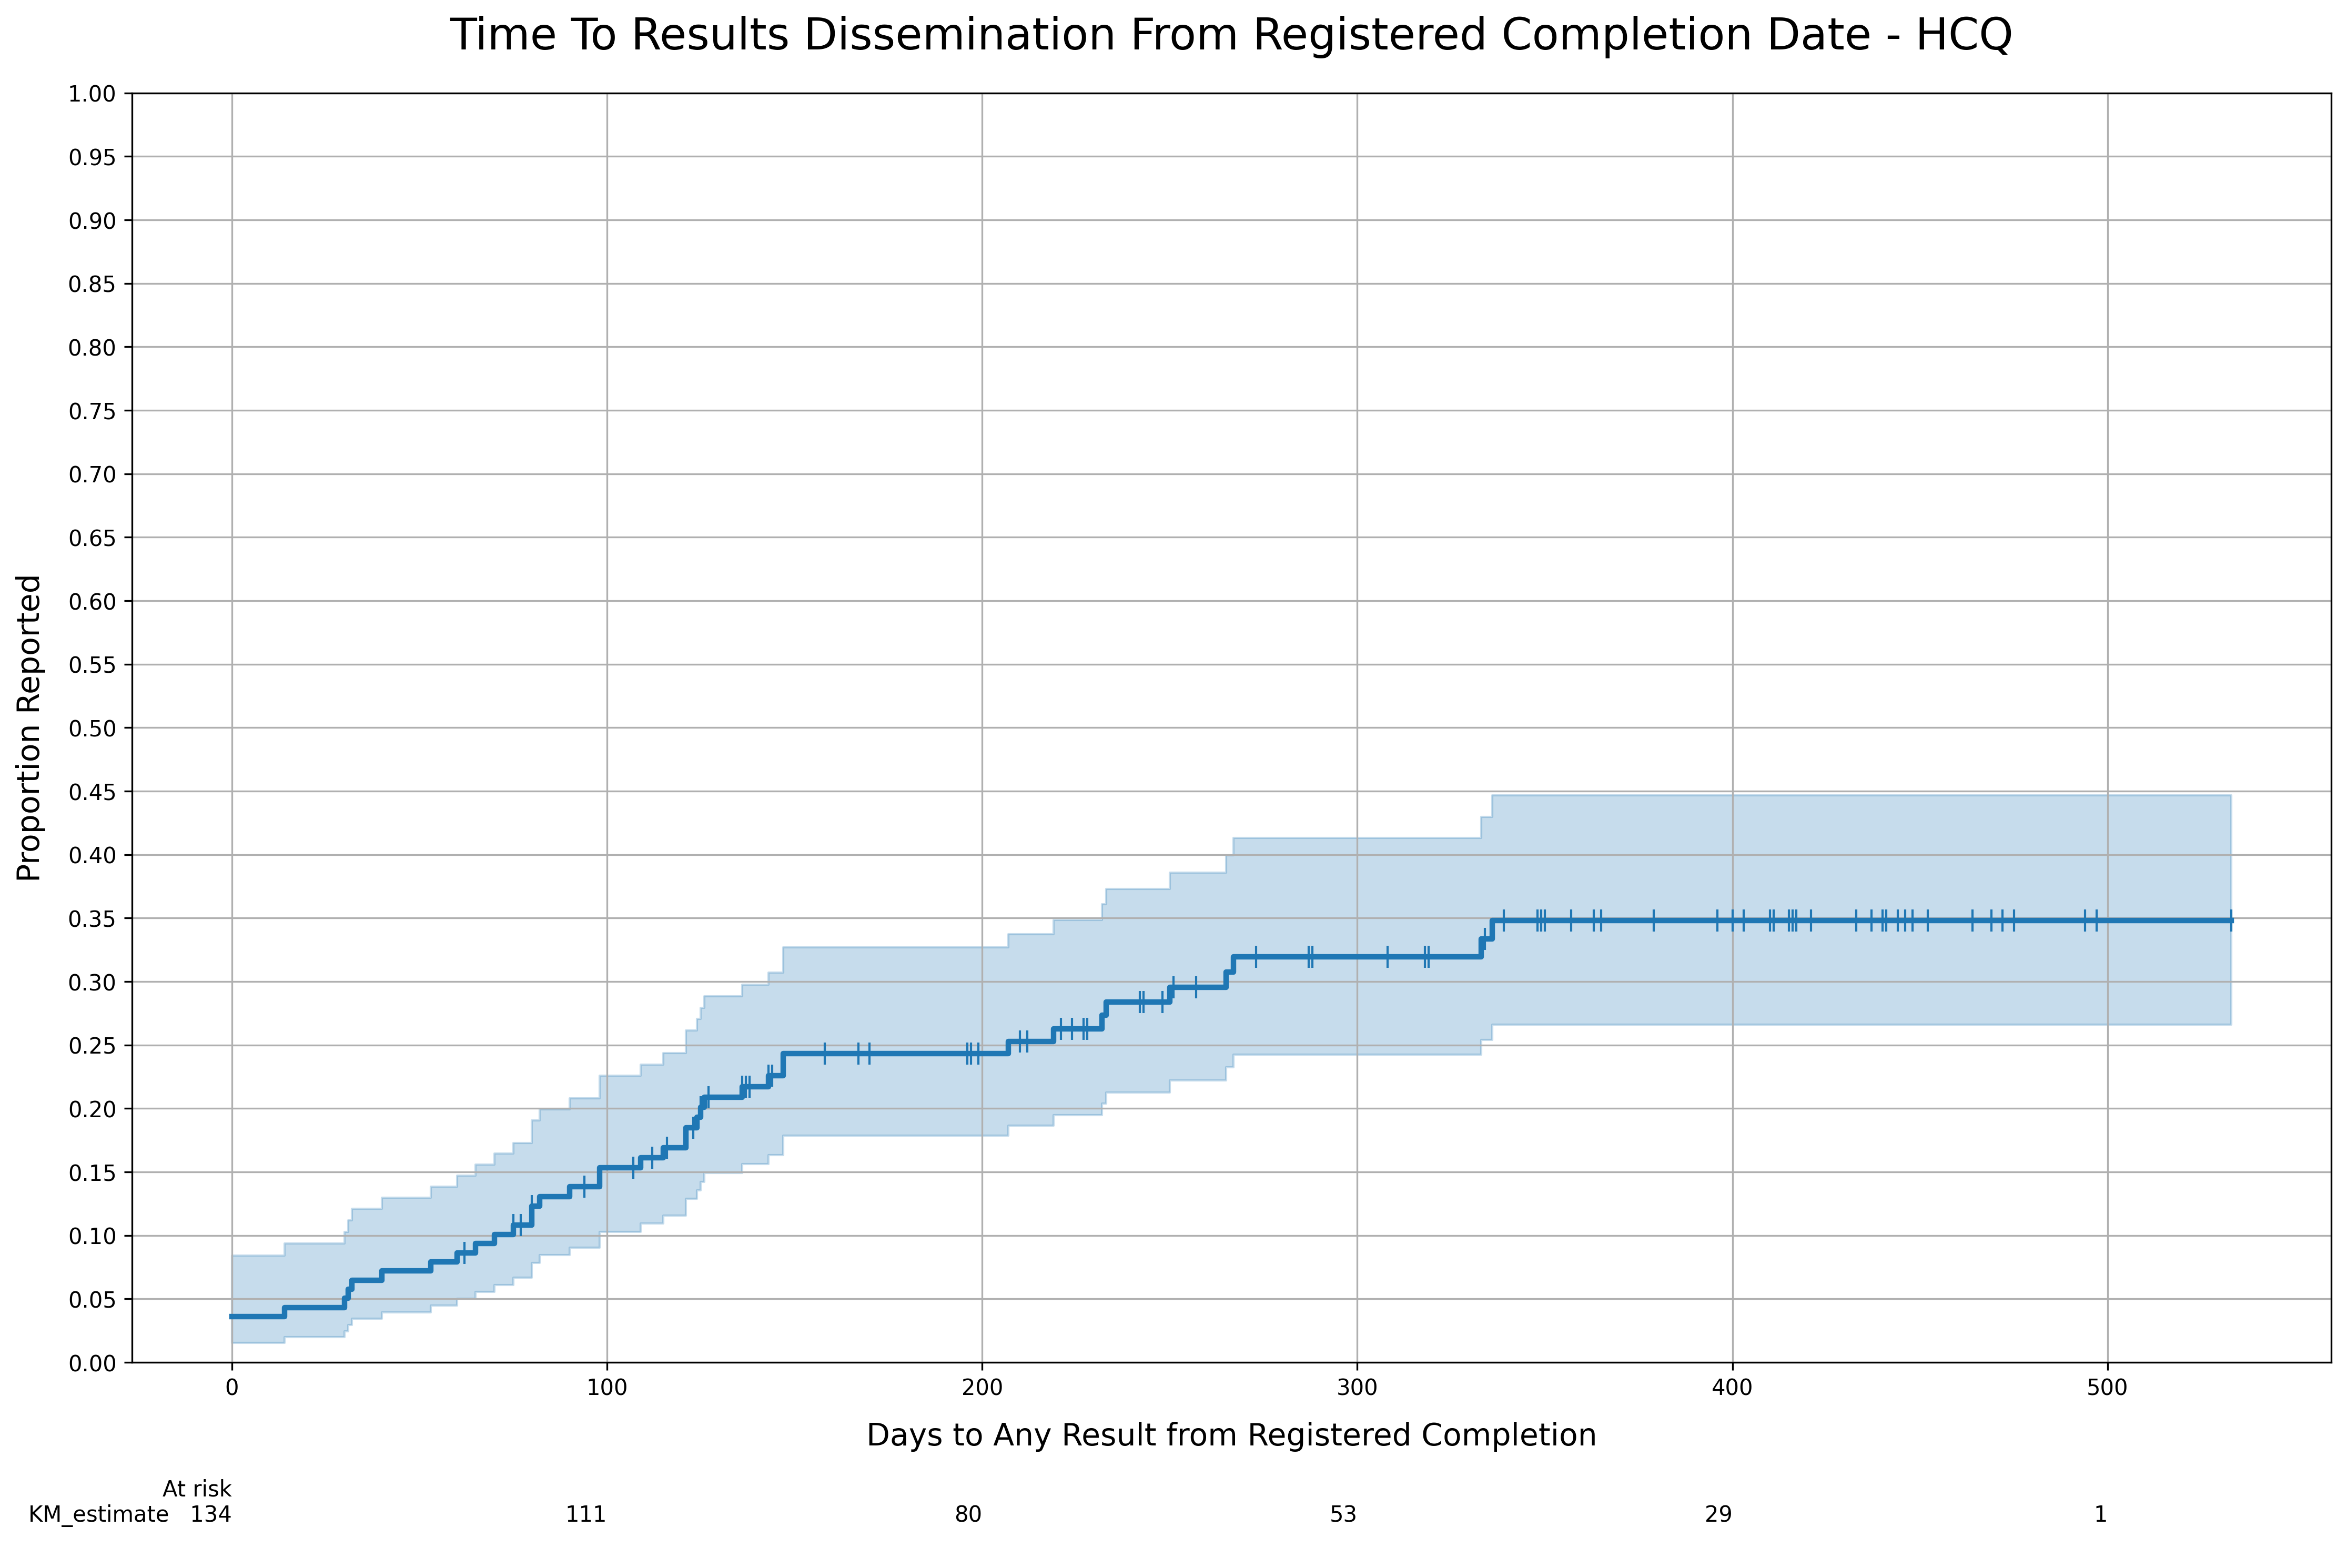

In [222]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T_hcq = hcq_pub.time_reporting_any_adj
E_hcq = hcq_pub.publication_any_adj

kmf_hcq = KaplanMeierFitter()
kmf_hcq.fit(T_hcq, E_hcq)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_hcq.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date - HCQ", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [232]:
ive_pub = ive[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
ive_pub['publication_any_adj'] = ive_pub['publication_any_adj'].astype(int)
ive_pub['time_reporting_any_adj'] = np.where(ive_pub['time_reporting_any_adj'] < 0, 0, ive_pub['time_reporting_any_adj'])

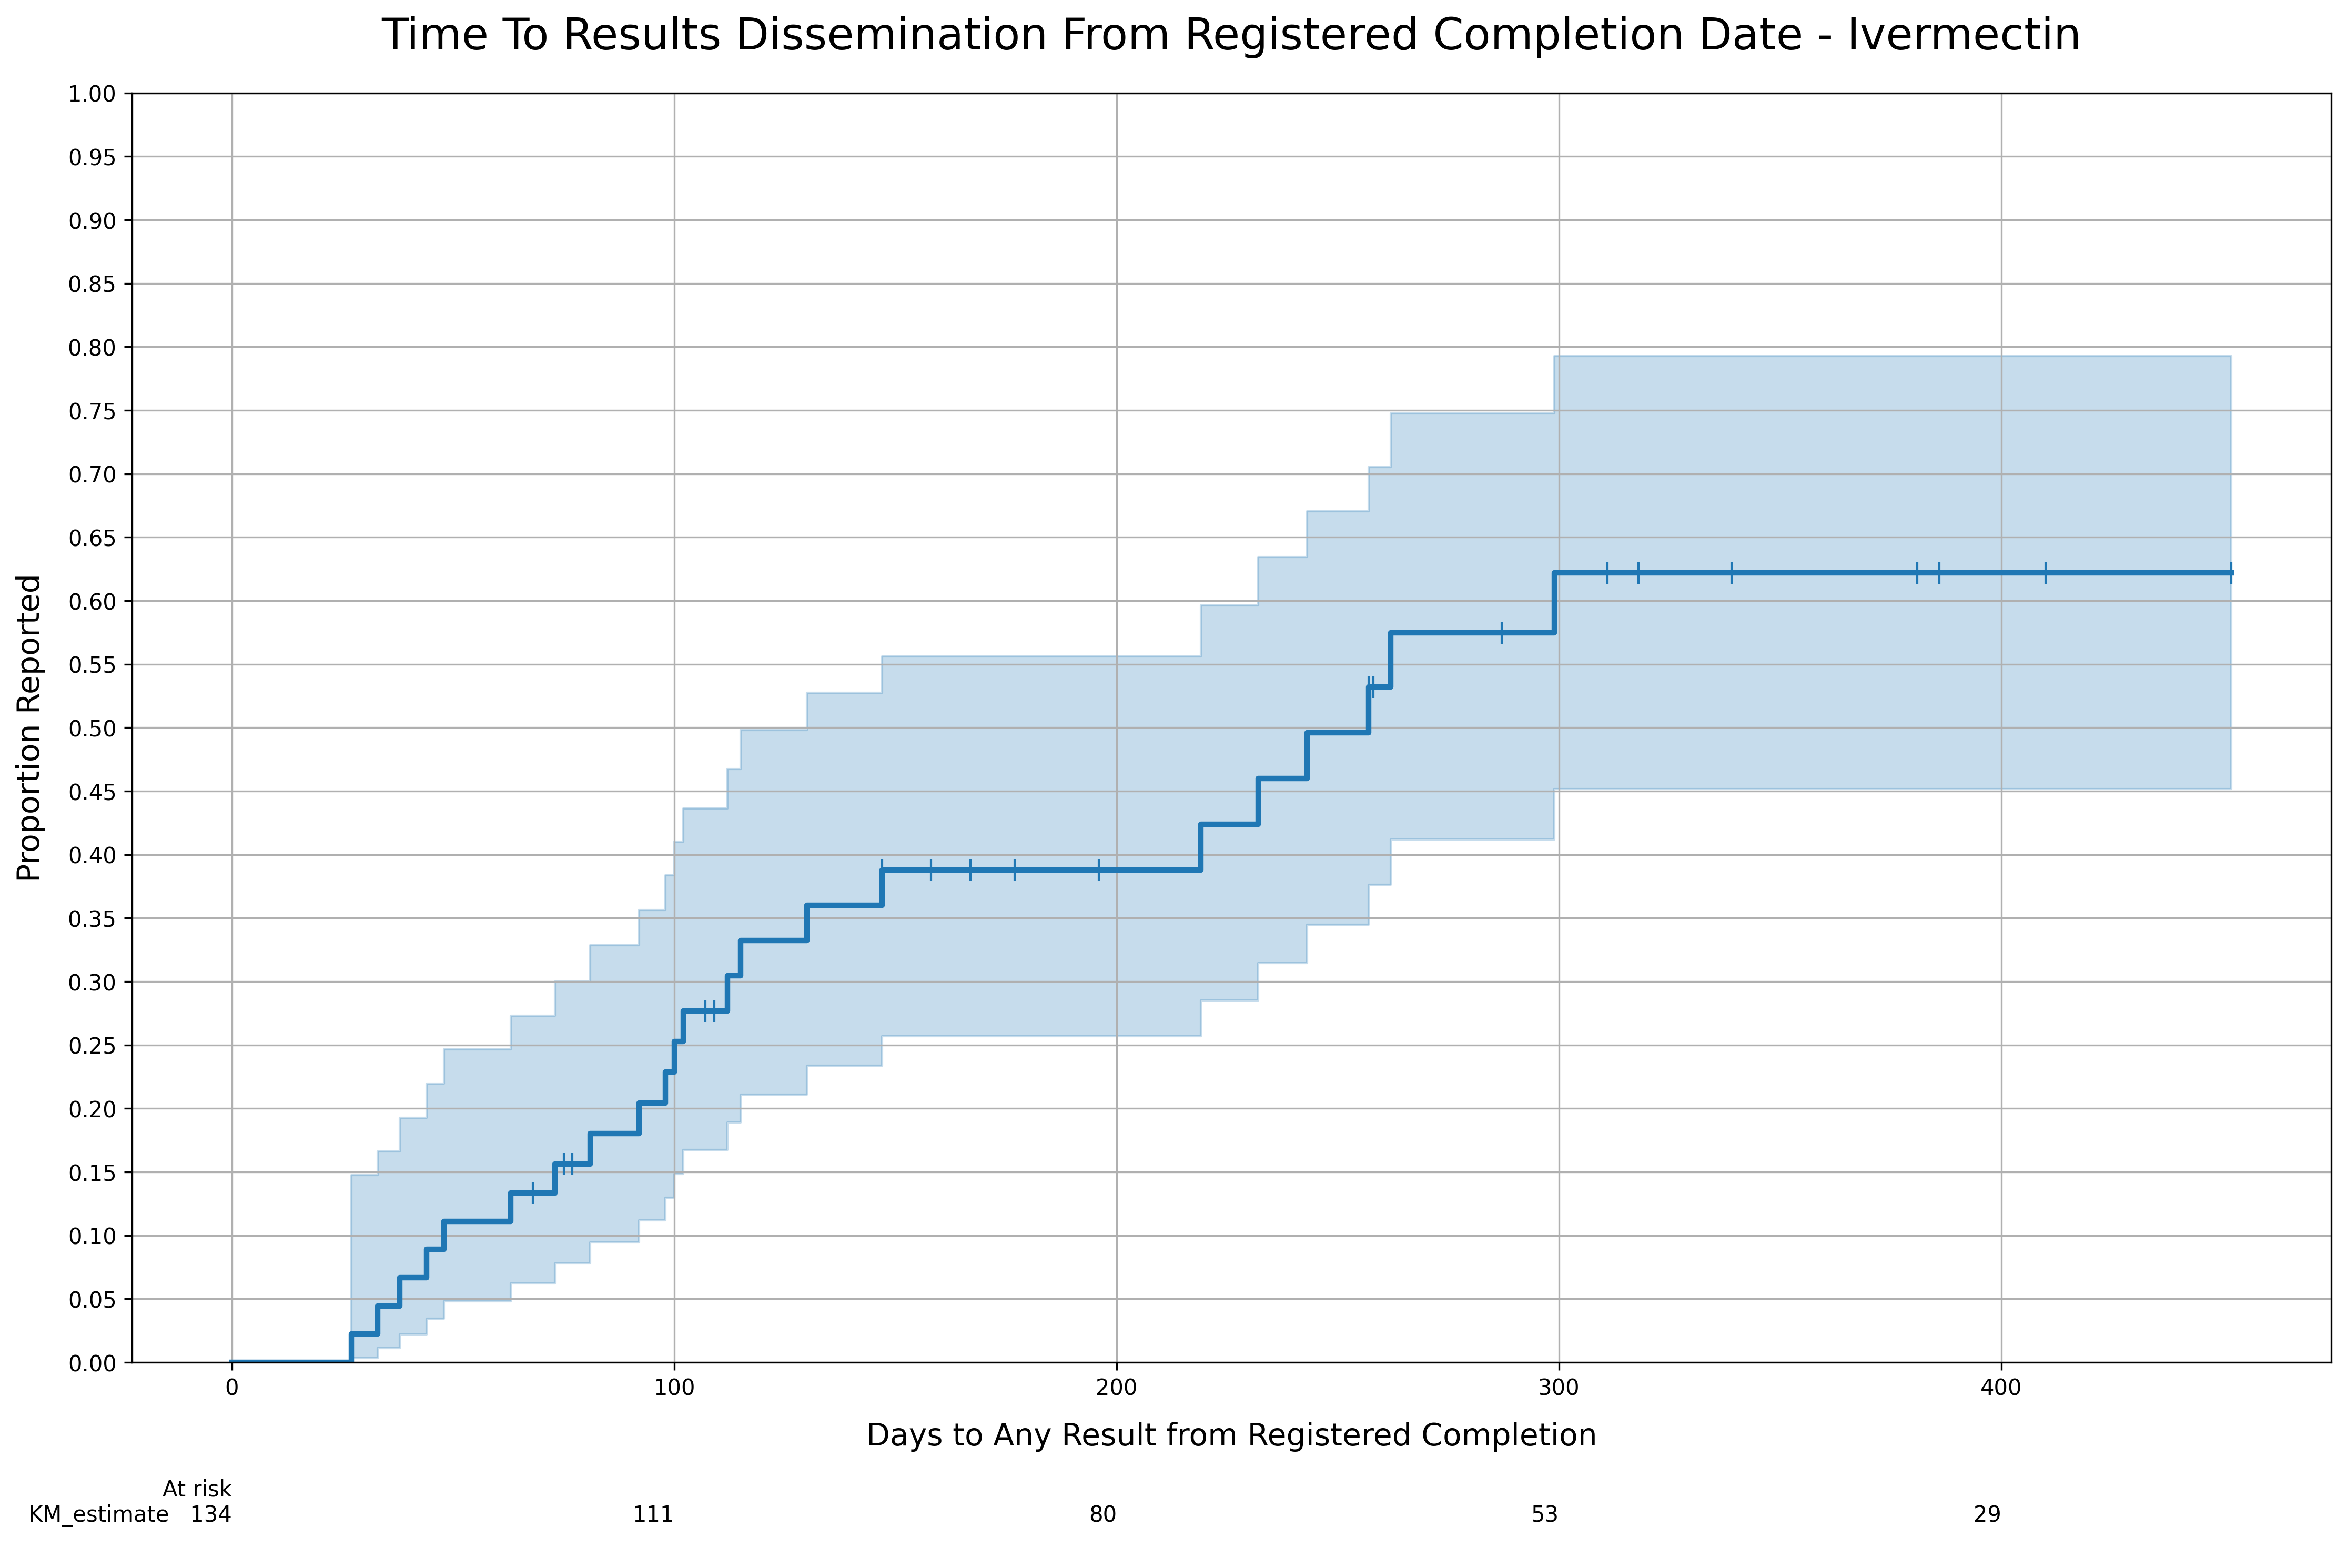

In [233]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T_ive = ive_pub.time_reporting_any_adj
E_ive = ive_pub.publication_any_adj

kmf_ive = KaplanMeierFitter()
kmf_ive.fit(T_ive, E_ive)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_ive.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date - Ivermectin", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

In [234]:
cp_pub = cp[['publication_any_adj', 'time_reporting_any_adj']].reset_index(drop=True)
cp_pub['publication_any_adj'] = cp_pub['publication_any_adj'].astype(int)
cp_pub['time_reporting_any_adj'] = np.where(cp_pub['time_reporting_any_adj'] < 0, 0, cp_pub['time_reporting_any_adj'])

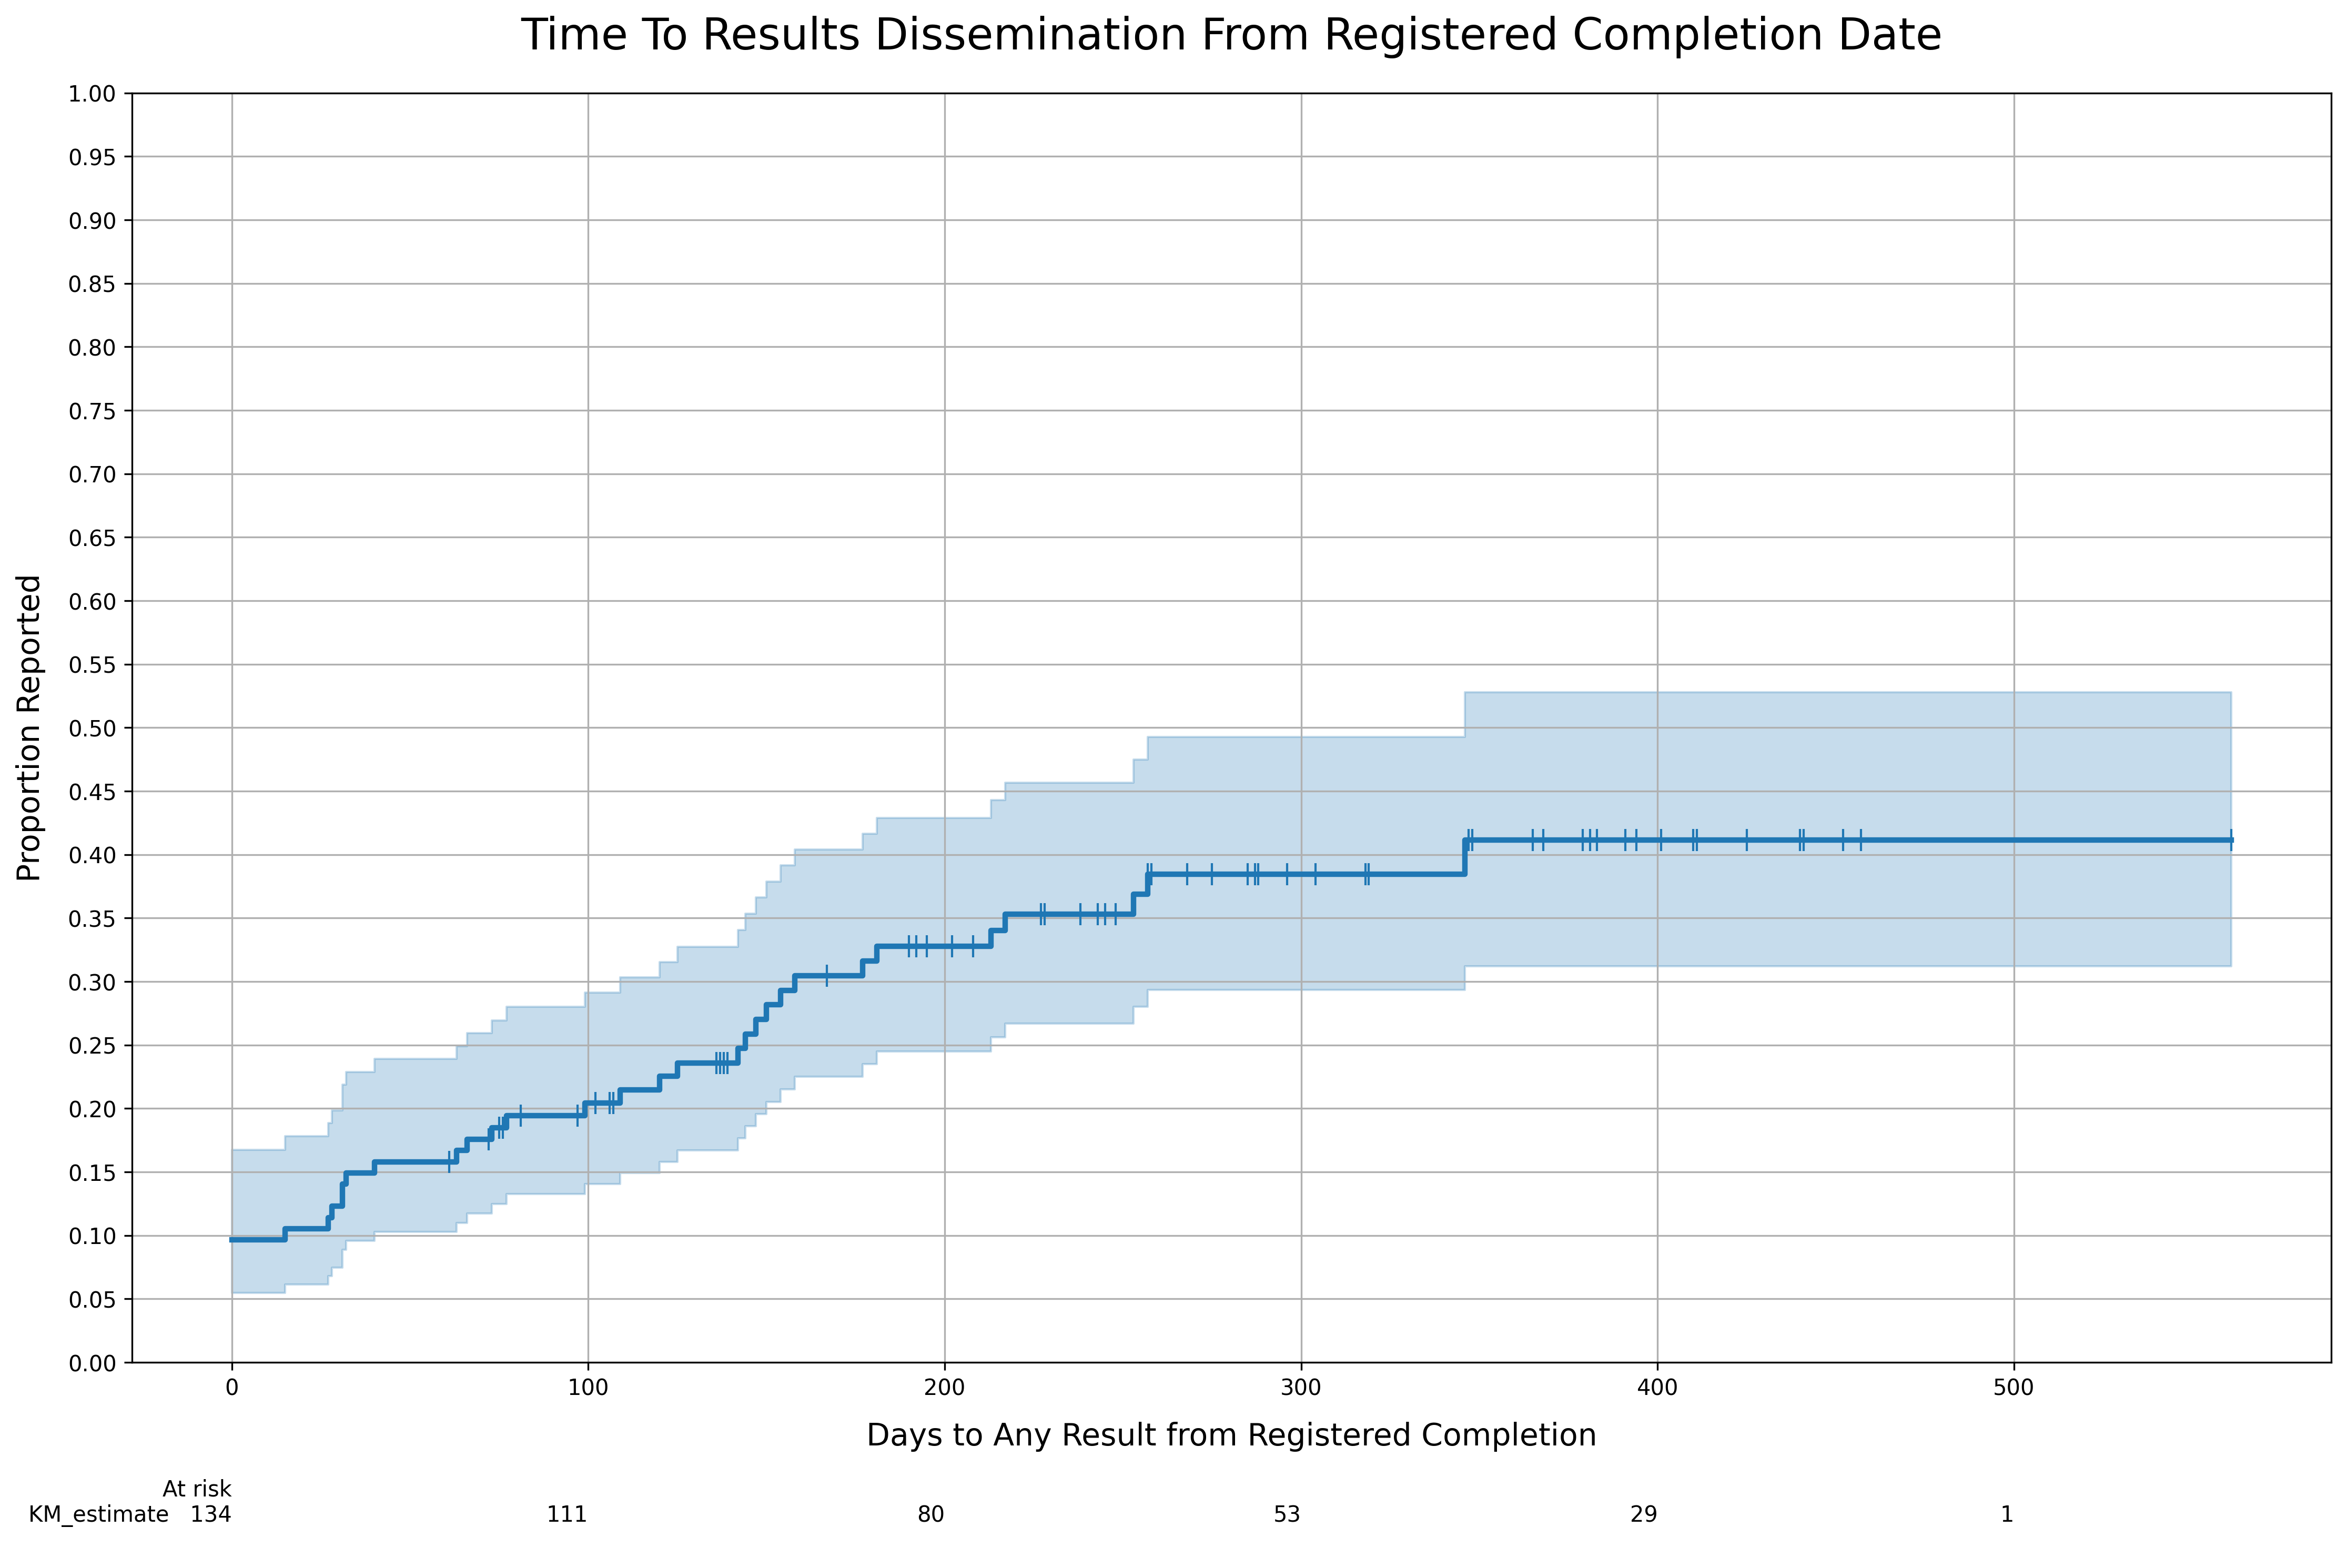

In [235]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

T_cp = cp_pub.time_reporting_any_adj
E_cp = cp_pub.publication_any_adj

kmf_cp = KaplanMeierFitter()
kmf_cp.fit(T_cp, E_cp)
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_cp.plot_cumulative_density(ci_show=True, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_any, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()

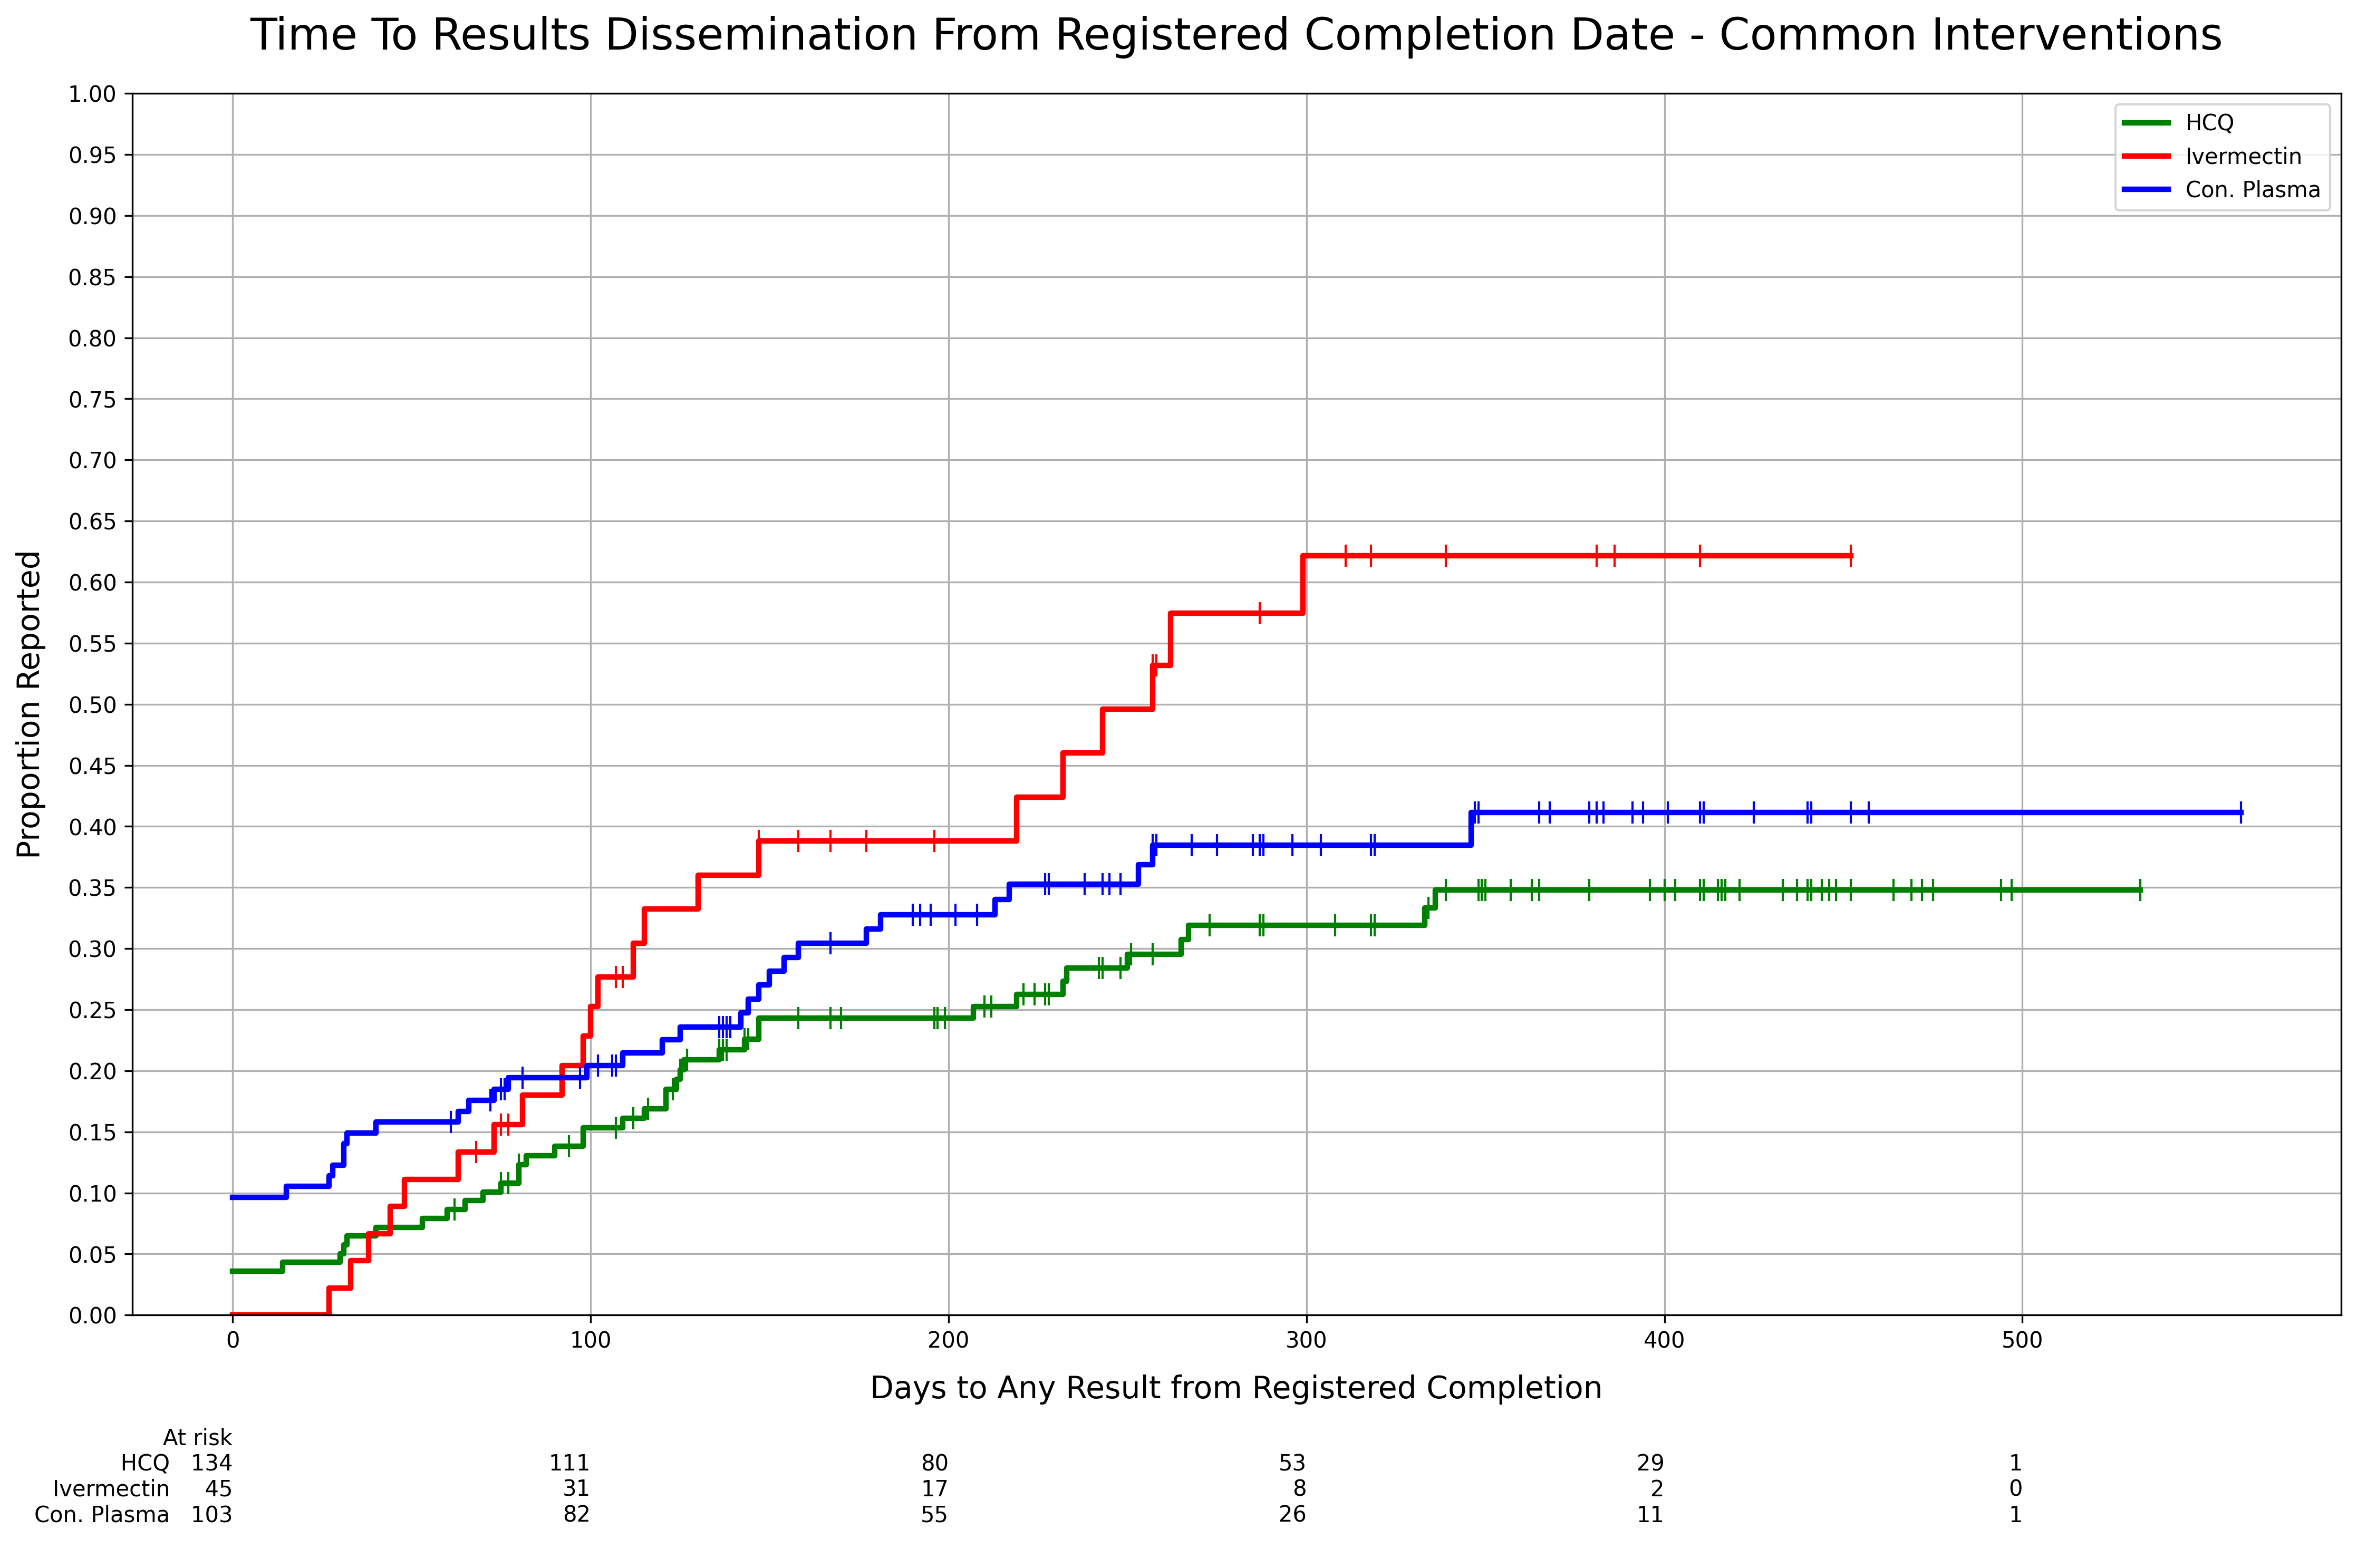

In [239]:
yticks = list(np.arange(0,1.05,.05))
fig = plt.figure(dpi=300)
ax = plt.subplot()

#T1 = phase_pub[phase_pub.pandemic_phase == 1].time_reporting_any_adj
#E1 = phase_pub[phase_pub.pandemic_phase == 1].publication_any_adj

kmf_1 = KaplanMeierFitter()
kmf_1.fit(T_hcq, E_hcq, label='HCQ')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_1.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='green')

#T2 = phase_pub[phase_pub.pandemic_phase == 2].time_reporting_any_adj
#E2 = phase_pub[phase_pub.pandemic_phase == 2].publication_any_adj

kmf_2 = KaplanMeierFitter()
kmf_2.fit(T_ive, E_ive, label='Ivermectin')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_2.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='red')


#T3 = phase_pub[phase_pub.pandemic_phase == 3].time_reporting_any_adj
#E3 = phase_pub[phase_pub.pandemic_phase == 3].publication_any_adj

kmf_3 = KaplanMeierFitter()
kmf_3.fit(T_cp, E_cp, label='Con. Plasma')
#ax = kmf_any.plot(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, yticks=yticks, figsize=(15, 10), grid=True, legend=False, ax=ax, lw=2.5)
ax = kmf_3.plot_cumulative_density(ci_show=False, show_censors=True, censor_styles={'ms':10, 'marker':'|'}, 
                                     yticks=yticks, figsize=(15, 10), grid=True, legend=True, ax=ax, lw=2.5, 
                                   color='blue')

ax.set_ylim([0, 1])

plt.title("Time To Results Dissemination From Registered Completion Date - Common Interventions", pad=20, fontsize=20)
plt.ylabel('Proportion Reported', labelpad=10, fontsize=14)
plt.xlabel('Days to Any Result from Registered Completion', labelpad=10, fontsize=14)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_1, kmf_2, kmf_3, rows_to_show = ['At risk'], ax=ax)
plt.tight_layout()